# Final full idea put together



joints to work with:
        # Define connections between joints
        connections = [
            ("R_EYE", "L_EYE"), ("R_EYE", "NOSE"), ("L_EYE", "NOSE"),
            ("R_EYE", "R_EAR"), ("L_EYE", "L_EAR"), ("R_SHOULDER", "L_SHOULDER"),
            ("R_SHOULDER", "R_ELBOW"), ("L_SHOULDER", "L_ELBOW"), ("R_ELBOW", "R_WRIST"),
            ("L_ELBOW", "L_WRIST"), ("R_SHOULDER", "R_HIP"), ("L_SHOULDER", "L_HIP"),
            ("R_HIP", "L_HIP"), ("R_HIP", "R_KNEE"), ("L_HIP", "L_KNEE"),
            ("R_KNEE", "R_ANKLE"), ("L_KNEE", "L_ANKLE"), ("R_WRIST", "R_1STFINGER"),
            ("R_WRIST", "R_5THFINGER"), ("L_WRIST", "L_1STFINGER"), ("L_WRIST", "L_5THFINGER"),
            ("R_ANKLE", "R_1STTOE"), ("R_ANKLE", "R_5THTOE"), ("L_ANKLE", "L_1STTOE"),
            ("L_ANKLE", "L_5THTOE"), ("R_ANKLE", "R_CALC"), ("L_ANKLE", "L_CALC"),
            ("R_1STTOE", "R_5THTOE"), ("L_1STTOE", "L_5THTOE"), ("R_1STTOE", "R_CALC"),
            ("L_1STTOE", "L_CALC"), ("R_5THTOE", "R_CALC"), ("L_5THTOE", "L_CALC"),
            ("R_1STFINGER", "R_5THFINGER"), ("L_1STFINGER", "L_5THFINGER")
        ]

ADDITIONS:
#, '1sttoe', '5thtoe' < ADD WHEN WE ADD TO DATA LOAD AND PREPARE IN MODULE %%writefile ml/feature_engineering/energy_exhaustion_metrics.py

look into why 
INFO: Angle column 'L_KNEE_angle' not found; skipping ROM metrics for L KNEE.
INFO: Angle column 'R_KNEE_angle' not found; skipping ROM metrics for R KNEE.


Below is a step‐by‐step walkthrough of how you can modify your existing pipeline to update the predictor variables, integrate additional metrics (asymmetry for all joints, power ratios, and ROM-based features), and then evaluate their importance relative to the target outcomes (exhaustion and injury risk). I’ve included plenty of breathing space between steps so you can follow along.

---

## Step 1: Review and Update Predictor Variables

**What We’re Changing:**

1. **Asymmetry Metrics:**  
   - **Before:** You had asymmetry for a few joints (e.g., elbows, knees).  
   - **Now:** Include asymmetry for wrists, shoulders, hips, ankles, feet—and, if data permits, compare left versus right sides of the feet (for landing and usage comparisons).  
   - **How:** For each paired joint (e.g., left/right shoulder), compute:
     ```python
     data['shoulder_asymmetry'] = np.abs(data['L_SHOULDER_energy'] - data['R_SHOULDER_energy'])
     ```
     Repeat for wrists, hips, ankles, and feet. For feet, if you have sub-foot measurements (e.g., left forefoot vs. right forefoot), compute those asymmetries as well.

2. **Power Ratios for All Joints:**  
   - **Before:** You had an ankle power ratio.  
   - **Now:** Compute power ratios for every joint pair.  
   - **How:** For example, for the shoulder:
     ```python
     data['shoulder_power_ratio'] = data['L_SHOULDER_power'] / (data['R_SHOULDER_power'] + 1e-6)
     ```
     Do similar computations for wrists, hips, knees, ankles, and feet.

3. **Range-of-Motion (ROM) Metrics:**  
   - **Before:** Your pipeline computed ROM for some joints and flagged extremes using deviation scores and binary flags.  
   - **Now:** For every joint you’re interested in (e.g., knee, shoulder, hip, etc.), compute:
     - The ROM:  
       ```python
       data['knee_ROM'] = data.groupby('trial_id')['knee_angle'].transform(lambda x: x.max() - x.min())
       ```
     - The deviation score relative to normative thresholds (e.g., using CDC normative values):  
       ```python
       normal_min_knee, normal_max_knee = 120, 135  # example values
       data['knee_ROM_deviation'] = np.maximum(0, normal_min_knee - data['knee_ROM']) + np.maximum(0, data['knee_ROM'] - normal_max_knee)
       ```
     - The binary flag indicating an extreme value:  
       ```python
       data['knee_ROM_extreme'] = ((data['knee_ROM'] < normal_min_knee) | (data['knee_ROM'] > normal_max_knee)).astype(int)
       ```
     - **Tip:** Repeat similar calculations for the shoulders, hips, ankles, and (if applicable) wrists.  
     
4. **Removing Non-Contributing Features:**  
   - You mentioned that the wrist angle at release is not useful for this model.  
   - **Action:** Remove or exclude this feature from your predictors:
     ```python
     predictors = [col for col in predictors if col != 'wrist_angle_release']
     ```

Take a breath—now we have updated the individual metrics.

---

## Step 2: Integrate Additional Metrics into the Feature Engineering Pipeline

### 2.1. Expand Asymmetry Calculations

For each joint pair, calculate asymmetry. For instance:
- **Shoulders, Hips, Ankles, Wrists, and Feet:**
  ```python
  for joint in ['shoulder', 'hip', 'ankle', 'wrist']:
      data[f'{joint}_asymmetry'] = np.abs(data[f'L_{joint.upper()}_energy'] - data[f'R_{joint.upper()}_energy'])
  # If foot sub-measurements exist:
  data['foot_asymmetry'] = np.abs(data['left_foot_energy'] - data['right_foot_energy'])
  ```
  
### 2.2. Compute Power Ratios Across All Joints

Similarly, loop over each joint to calculate a power ratio:
  ```python
  for joint in ['shoulder', 'hip', 'knee', 'ankle', 'wrist']:
      data[f'{joint}_power_ratio'] = data[f'L_{joint.upper()}_power'] / (data[f'R_{joint.upper()}_power'] + 1e-6)
  # For feet, if you have sub-joint or left/right foot power:
  data['foot_power_ratio'] = data['left_foot_power'] / (data['right_foot_power'] + 1e-6)
  ```

### 2.3. Incorporate Expanded ROM Metrics

For each joint (e.g., knee, shoulder, hip, ankle), compute ROM, deviation scores, and binary flags. Example for the knee was given above; repeat for each joint:
  ```python
  # Example for the shoulder (adjust normative thresholds accordingly)
  normal_min_shoulder, normal_max_shoulder = 0, 150  # example values for abduction
  data['shoulder_ROM'] = data.groupby('trial_id')['shoulder_angle'].transform(lambda x: x.max() - x.min())
  data['shoulder_ROM_deviation'] = np.maximum(0, normal_min_shoulder - data['shoulder_ROM']) + np.maximum(0, data['shoulder_ROM'] - normal_max_shoulder)
  data['shoulder_ROM_extreme'] = ((data['shoulder_ROM'] < normal_min_shoulder) | (data['shoulder_ROM'] > normal_max_shoulder)).astype(int)
  ```

### 2.4. Remove the Wrist Angle at Release

Before proceeding to the model training phase, ensure you drop or ignore the `wrist_angle_release` feature:
  ```python
  if 'wrist_angle_release' in data.columns:
      data.drop(columns=['wrist_angle_release'], inplace=True)
  ```

Let’s take another breath—now we have a fully enriched set of predictor variables.

---

## Step 3: Define Predictor (X) and Target (y) Variables for Each Model

### 3.1. Exhaustion Prediction

- **Target Variable (y):**  
  - `by_trial_exhaustion_score` (continuous measure)
  logic:
  trial time is every .33 seconds
    data['exhaustion_rate'] = data['by_trial_exhaustion_score'].diff() / data['by_trial_time'].diff()

- **Predictor Variables (X) should now include:**  
  - **Aggregated energy and power metrics:** joint_power, joint_energy  
  - **Asymmetry metrics:** elbow_asymmetry, knee_asymmetry, shoulder_asymmetry, hip_asymmetry, ankle_asymmetry, wrist_asymmetry, foot_asymmetry  
  - **Power ratios:** shoulder_power_ratio, hip_power_ratio, knee_power_ratio, ankle_power_ratio, wrist_power_ratio, foot_power_ratio  
  - **Lagged and rolling features:** exhaustion_lag1, power_avg_5, rolling_energy_std  
  - **Simulated physiological proxies:** simulated_HR, energy_acceleration  
  - **Anthropometrics:** player_height_in_meters, player_weight_in_kg  
  - **ROM-based features:** For each joint, include ROM, deviation scores (e.g., knee_ROM_deviation), and binary extreme flags (e.g., knee_ROM_extreme)

### 3.2. Injury Risk Prediction

- **Target Variable (y):**  
  - `injury_risk` (binary: 0 for low risk, 1 for high risk)
  logic:
    data['rolling_exhaustion'] = data['by_trial_exhaustion_score'].rolling(window=rolling_window).sum()
    data['injury_risk'] = np.where(data['rolling_exhaustion'] > quantile_75, 1, 0)

- **Predictor Variables (X) should include:**  
  - Many of the same metrics as exhaustion prediction but with an added emphasis on movement asymmetries and ROM abnormalities:
    - joint_power, joint_energy  
    - All asymmetry metrics  
    - All power ratios  
    - Lagged features like exhaustion_lag1  
    - Rolling averages (power_avg_5) and simulated_HR  
    - Anthropometrics  
    - **ROM Metrics:** All computed ROM values, deviation scores, and binary flags for each joint

### 3.2. Injury Risk Prediction

- **Target Variable (y):**  
  - knee, shoulder, ankle, and wrist `injury_risk` (binary: 0 for low risk, 1 for high risk)
  logic:
    data['{joint}_exhaustion_rate'] = data['{joint}_by_trial_exhaustion_score'].diff() / data['by_trial_time'].diff()
    data['{joint}_rolling_exhaustion'] = data['{joint}_by_trial_exhaustion_score'].rolling(window=rolling_window).sum()
    data['{joint}_injury_risk'] = np.where(data['{joint}_rolling_exhaustion'] > quantile_75, 1, 0)

- **Predictor Variables (X) should include:**  
  - Many of the same metrics as exhaustion prediction but with an added emphasis on movement asymmetries and ROM abnormalities:
    - joint_power, joint_energy  
    - All asymmetry metrics  
    - All power ratios  
    - Lagged features like exhaustion_lag1  
    - Rolling averages (power_avg_5) and simulated_HR  
    - Anthropometrics  
    - **ROM Metrics:** All computed ROM values, deviation scores, and binary flags for each joint
Take a breath—you now have a robust and enriched feature set for both exhaustion and injury risk predictions.

---

## Step 4: Train Models and Evaluate Feature Importance

### 4.1. Model Building

- **Exhaustion Prediction Model (Regression):**  
  Build an LSTM or any other regression model using the enriched feature set.
- **Injury Risk Prediction Model (Classification):**  
  Similarly, train a classification model using your combined features.

### 4.2. Evaluating Feature Importance

Once the models are trained, determine the relative importance of each feature using methods such as:

1. **Permutation Importance:**  
   Shuffle each predictor and measure the drop in performance.
   ```python
   from sklearn.inspection import permutation_importance
   results = permutation_importance(trained_model, X_test, y_test, scoring='neg_mean_absolute_error')
   importance_df = pd.DataFrame({'feature': X_test.columns, 'importance': results.importances_mean})
   ```

2. **Tree-based Methods:**  
   If you are using a random forest or gradient boosting method, use built-in feature importance metrics.
   ```python
   importance_df = pd.DataFrame({
       'feature': X_test.columns,
       'importance': trained_model.feature_importances_
   })
   ```

3. **SHAP Analysis:**  
   SHAP values can help you understand the impact of each feature on individual predictions.
   ```python
   import shap
   explainer = shap.TreeExplainer(trained_model)
   shap_values = explainer.shap_values(X_test)
   shap.summary_plot(shap_values, X_test)
   ```

4. **Correlation Analysis:**  
   Compute Pearson or Spearman correlation coefficients between each predictor and the target variable for a first-pass indication.

After evaluating, you can identify which features—be it asymmetry metrics, power ratios, or ROM-based measures—are most predictive of exhaustion or injury risk.

Take one final breath—your integrated pipeline now not only includes all the desired metrics but also has a clear process to assess which features are most influential in predicting the target outcomes.

---

## Final Recap

- **Updated Features:**  
  We added asymmetry calculations for all major joints (wrists, shoulders, hips, ankles, feet), computed power ratios for each joint pair, and expanded our ROM analysis to include deviation scores and binary flags.
  
- **Feature Removal:**  
  The wrist angle at release was removed as it was not helpful for the prediction task.
  
- **Integration:**  
  All these features were added to both the exhaustion and injury risk predictor sets.
  
- **Evaluation:**  
  We then laid out steps to train models and perform feature importance analyses (using permutation importance, tree-based methods, and SHAP).

By following these steps, you ensure that your workout simulation model incorporates comprehensive biomechanical metrics, enhancing the predictive power for both fatigue (exhaustion) and joint injury risk.




# Notes

Based on the CDC resource (see citeturn1search28 and the archived CDC page at https://archive.cdc.gov/www_cdc_gov/ncbddd/jointrom/index.html), here is an example of normative thresholds for joint range of motion in adults. (Note that these numbers are approximate—actual values may vary slightly by population and measurement method.)

- **Shoulder:**  
  - Flexion: Approximately 0° to 180°  
  - Abduction: Approximately 0° to 150°

- **Elbow:**  
  - Flexion: Approximately 0° to 150°  
  - Extension: 0° (full extension)

- **Wrist:**  
  - Flexion: Approximately 0° to 80°  
  - Extension: Approximately 0° to 70°

- **Hip:**  
  - Flexion: Approximately 0° to 120°  
  - Extension: Approximately 0° to 30°

- **Knee:**  
  - Flexion: Approximately 0° to 135°  
  - Extension: 0° (full extension)

- **Ankle:**  
  - Dorsiflexion: Approximately 0° to 20°  
  - Plantarflexion: Approximately 0° to 50°

### How These Thresholds Would Work in the Pipeline

1. **Data Extraction:**  
   After loading your granular data, you’ll extract joint angle data for each joint over each free throw. For example, if you have a column named “knee_angle,” you can calculate its maximum and minimum value during each trial.

2. **ROM Calculation:**  
   For each joint, compute the range of motion as:  
   \[
   \text{ROM} = \max(\text{joint\_angle}) - \min(\text{joint\_angle})
   \]
   This gives you the actual ROM for that trial.

3. **Comparison with Normative Thresholds:**  
   Using the thresholds above, you can then determine if the measured ROM is “extreme” (i.e., either below the lower bound or above the upper bound). For example, for the knee:
   - **Normal:** 0° to 135° of flexion  
   - **Abnormal/Extreme:** Less than 120° might be considered too stiff, while more than 135° (or above a clinically accepted maximum) could suggest hypermobility.
   
   You could flag these cases with:
   ```python
   normal_min_knee, normal_max_knee = 120, 135  # example thresholds
   data['knee_ROM'] = data.groupby('trial_id')['knee_angle'].transform(lambda x: x.max() - x.min())
   data['knee_ROM_extreme'] = ((data['knee_ROM'] < normal_min_knee) | (data['knee_ROM'] > normal_max_knee)).astype(int)
   ```
   Similar computations can be done for the shoulder, wrist, hip, and ankle.

4. **Using as Predictors:**  
   - For **injury risk prediction**, add these ROM metrics (or binary flags/deviation scores) to your feature set. The idea is that joints operating outside of their normative ranges may be at increased risk for injury.
   - For **exhaustion prediction**, while ROM might be a secondary predictor compared to energy and power, abnormal or highly variable ROM might still indicate inefficient or compensatory movement patterns that could correlate with fatigue.

5. **Integration with Other Metrics:**  
   Once these new ROM features are computed, they can be included alongside energy, power, and fatigue measures in both your exploratory analysis and predictive modeling steps. For instance, abnormal ROM in the shoulder (e.g., a flexion range below 170° or above 180°) might combine with high simulated heart rate or high energy acceleration to signal increased injury risk.

### Final Thoughts

Incorporating these threshold values from the CDC gives you objective criteria to flag when a joint’s range of motion is not within a healthy or expected range. When integrated into your pipeline, these metrics help provide a fuller picture of an athlete’s biomechanics—combining the magnitude of force (energy and power) with the quality of movement (ROM and its extremes). This approach can improve injury risk predictions and provide actionable insights for corrective interventions.

Sources:  
citeturn1search28 (Encyclopedia.com on Range of Motion) and the archived CDC page at https://archive.cdc.gov/www_cdc_gov/ncbddd/jointrom/index.html.

Below is an overview of the best ways to incorporate extreme range‐of‐motion (ROM) metrics into your workflow, along with a discussion of how these metrics can serve as an “injury index” by flagging movements that push joints toward their limits—potentially indicating over-stress in compromised positions.

---

### Incorporating Extreme ROM Metrics into the Workflow

#### 1. **Data Extraction & Calculation**

- **Extract Joint Angle Data:**  
  From your granular (frame-by-frame) dataset, extract the joint angle time series for each joint of interest (e.g., knee_angle, shoulder_angle, etc.) for each free throw or trial.

- **Compute the ROM for Each Joint:**  
  For each trial, calculate the range of motion as:  
  \[
  \text{ROM} = \max(\text{joint\_angle}) - \min(\text{joint\_angle})
  \]
  For example, if the knee angle varies between 30° and 140° in one trial, the ROM for that trial is 110°.

#### 2. **Comparison with Normative Thresholds**

Based on the CDC resource, you have normative thresholds for each joint. For instance:
  
- **Shoulder:**  
  - Flexion: 0° to 180°  
  - Abduction: 0° to 150°
  
- **Elbow:**  
  - Flexion: 0° to 150°  
  - Extension: 0° (full extension)
  
- **Wrist:**  
  - Flexion: 0° to 80°  
  - Extension: 0° to 70°
  
- **Hip:**  
  - Flexion: 0° to 120°  
  - Extension: 0° to 30°
  
- **Knee:**  
  - Flexion: 0° to 135°  
  - Extension: 0°
  
- **Ankle:**  
  - Dorsiflexion: 0° to 20°  
  - Plantarflexion: 0° to 50°

For each joint, decide on “extreme” thresholds that may indicate over-stress. For example, for the knee, you might define:
- **Normal Knee Flexion:** 0° to 135°  
- **Abnormally Restricted (Stiff) Knee:** ROM less than 120°  
- **Abnormally Excessive (Hypermobile) Knee:** ROM greater than 135° (or above an accepted clinical maximum)

#### 3. **Creating ROM-Based Features**

- **Deviation Metrics:**  
  For each joint, calculate a deviation measure that quantifies how far the measured ROM deviates from the normative (or “optimal”) range. For example:
  ```python
  # For the knee, using illustrative thresholds
  normal_min_knee, normal_max_knee = 120, 135
  data['knee_ROM'] = data.groupby('trial_id')['knee_angle'].transform(lambda x: x.max() - x.min())
  data['knee_ROM_deviation'] = np.maximum(0, normal_min_knee - data['knee_ROM']) + np.maximum(0, data['knee_ROM'] - normal_max_knee)
  ```
  This continuous deviation score provides a “meter” of how far the joint is operating outside the normal range.

- **Binary Flags:**  
  Alternatively, create binary flags that indicate whether a joint’s ROM is extreme:
  ```python
  data['knee_ROM_extreme'] = ((data['knee_ROM'] < normal_min_knee) | (data['knee_ROM'] > normal_max_knee)).astype(int)
  ```
  These flags can be used directly in your injury risk prediction models.

#### 4. **Integrating into the Injury Index**

- **Weighted Injury Index:**  
  Combine the deviation scores (or binary flags) from multiple joints into an aggregated “injury index.” For instance, you might take a weighted sum of the deviation scores for key joints (e.g., knee, shoulder, hip) based on their importance in your analysis:
  ```python
  data['injury_index'] = (w1 * data['knee_ROM_deviation'] + 
                          w2 * data['shoulder_ROM_deviation'] + 
                          w3 * data['hip_ROM_deviation'])
  ```
  where *w1*, *w2*, and *w3* are weights determined either by domain expertise or through feature importance analysis.

- **Interpretation:**  
  The injury index provides a quantitative measure of how “compromised” a joint (or combination of joints) is by operating at extreme ranges. A higher index suggests that the athlete’s joints are spending more time (or exhibiting more variability) near their extremes, which could be a sign of over-stress and a higher risk for injury.

#### 5. **Integration with Other Metrics and Modeling**

- **As Predictors:**  
  Add these ROM-derived metrics (both continuous deviations and binary flags) to your predictor set (X) in the injury risk model. They can be used alongside existing metrics like joint_energy, energy_acceleration, and simulated_HR.
  
- **Model Analysis:**  
  Run feature importance or SHAP analysis on the injury risk model to see how strongly these ROM features contribute to predicting injury. If they are significant, it confirms that operating in extreme ROM is an important risk factor.

- **Dynamic Feedback:**  
  In a real-time or near-real-time monitoring system, these ROM metrics could provide immediate feedback. For example, if an athlete’s knee ROM suddenly deviates from the norm, the system could alert coaches or trigger a warning to adjust the training load.

---

### Final Thoughts

By incorporating extreme range-of-motion metrics, your workflow gains a new dimension that quantifies not only the volume of joint movement (energy and power) but also its quality. This allows you to:
- **Detect Abnormal Movement Patterns:** Identify when joints are operating at the edge of their healthy range.
- **Quantify Over-Stress:** Create an injury index that reflects cumulative stress from abnormal ROM.
- **Enhance Predictive Models:** Integrate these metrics into both exhaustion and injury risk prediction, potentially increasing model accuracy.
- **Support Preventive Interventions:** Use the injury index as a real-time tool to flag potentially compromised movements, guiding corrective actions or modifications in training.

In summary, incorporating extreme ROM metrics (using the thresholds from the CDC resource) into your pipeline could indeed provide a valuable “meter” that measures the degree of flexion towards the extremes. This, in turn, serves as an injury index that captures over-stress in compromised positions—enhancing your ability to predict and ultimately prevent injuries.


Below is a discussion of how you might add abnormal joint ROM patterns and additional metrics—ultimately building an “injury index”—into your workflow. This discussion expands on the concept using the normative thresholds from the CDC resource and explains step by step how these extra metrics can be computed, integrated, and used to flag over-stress or compromised positions that might increase injury risk.

---

### 1. Concept Overview

Our goal is to enhance the existing biomechanical pipeline by adding range-of-motion (ROM) metrics that capture not only whether a joint is moving but whether it is operating within a healthy, normative range. Using the CDC thresholds as guidelines (for example, shoulder flexion is normally 0°–180°, knee flexion is normally 0°–135°, etc.), we can flag instances where a joint’s ROM is either too restricted or too excessive. These abnormal values may indicate:
  
- **Stiffness or limited mobility:** Suggesting potential overuse, injury, or compensatory movement patterns.
- **Hypermobility:** Which might also lead to instability and increase the risk of injury.

By quantifying how far a joint’s ROM deviates from the normative range, we can create additional features that serve as predictors. When combined with energy, power, and fatigue metrics, these ROM-derived metrics could help form an “injury index” that measures the cumulative stress on an athlete’s joints.

---

### 2. Calculating Abnormal ROM Metrics

**Step A. Data Extraction & ROM Calculation**

- **Extract Joint Angle Data:**  
  For each trial (or free throw), extract the time series for each joint’s angle. For instance, for the knee, use the column `knee_angle`.

- **Compute ROM:**  
  Calculate the ROM per trial as:
  \[
  \text{ROM} = \max(\text{joint\_angle}) - \min(\text{joint\_angle})
  \]
  For example, if during a trial, `knee_angle` varies between 30° and 140°, the ROM is 110°.

**Step B. Compare with Normative Thresholds**

Using the CDC resource, we have normative ranges—for instance:
  
- **Knee:**  
  - Normal flexion: 0° to 135°
  - Abnormal/Extreme: A ROM below 120° might be too restricted (stiff), and above 135° could suggest hypermobility.

You would then:
  
- **Compute Deviation Metrics:**  
  Determine how far the measured ROM is from the “ideal” range. For the knee:
  ```python
  normal_min_knee, normal_max_knee = 120, 135  # Example thresholds
  data['knee_ROM'] = data.groupby('trial_id')['knee_angle'].transform(lambda x: x.max() - x.min())
  data['knee_ROM_deviation'] = np.maximum(0, normal_min_knee - data['knee_ROM']) + np.maximum(0, data['knee_ROM'] - normal_max_knee)
  ```
  This continuous deviation score indicates how far the knee is from its optimal ROM.

- **Create Binary Flags:**  
  Alternatively, or additionally, create a flag to indicate if the ROM is extreme:
  ```python
  data['knee_ROM_extreme'] = ((data['knee_ROM'] < normal_min_knee) | (data['knee_ROM'] > normal_max_knee)).astype(int)
  ```

Similar calculations would be applied to other joints (shoulder, elbow, wrist, hip, ankle) using their respective normative ranges.

---

### 3. Building an Injury Index

Once you have the abnormal ROM metrics for key joints, you can combine these to form an overall “injury index.” This index quantifies how much an athlete’s joints are operating outside of their healthy ranges:

- **Weighted Sum or Composite Score:**  
  For example, if you have deviation scores for the knee, shoulder, and hip, you might compute:
  ```python
  data['injury_index'] = (w1 * data['knee_ROM_deviation'] + 
                          w2 * data['shoulder_ROM_deviation'] + 
                          w3 * data['hip_ROM_deviation'])
  ```
  Here, *w1*, *w2*, and *w3* are weights you can set based on domain expertise or derived from feature importance analysis. Alternatively, you could sum the binary flags to get a count of joints with abnormal ROM.

- **Interpreting the Index:**  
  A higher injury index means that, across multiple joints, the athlete is operating further outside normative ranges. This could signal that the body is under stress or that certain joints are compensating—both of which are risk factors for injury.

---

### 4. Integrating into the Workflow

#### **A. During Data Preparation and Feature Engineering:**

- **Calculate ROM Metrics:**  
  Add a routine in your joint feature preparation step that calculates the ROM for each joint, compares it to normative thresholds, and computes both deviation scores and binary flags.

- **Include in Feature Set:**  
  Integrate these ROM metrics alongside your existing features (joint_energy, joint_power, energy_acceleration, simulated_HR, etc.). This way, when you perform lagged and rolling calculations, the ROM data is also available for analysis.

#### **B. In Predictive Modeling:**

- **Injury Risk Prediction Model:**  
  Add the abnormal ROM metrics (e.g., knee_ROM_deviation, knee_ROM_extreme, etc.) as additional predictors (X). The hypothesis is that if an athlete’s ROM is frequently outside the normative range, this could indicate increased injury risk.

- **Exhaustion Prediction Model:**  
  While ROM might be less directly linked to exhaustion, abnormal or highly variable ROM might also indicate inefficiencies in movement that contribute to fatigue. Thus, these metrics can serve as secondary predictors.

- **Analysis & Interpretation:**  
  Use feature importance analyses (e.g., SHAP values) to assess how these new ROM features contribute to predicting injury risk. If they emerge as significant predictors, they can guide further intervention strategies.

#### **C. Real-Time Monitoring and Feedback:**

- **Dynamic Injury Index:**  
  In a real-time monitoring system, compute the injury index on the fly during a free throw or training session. If the index exceeds a critical threshold, the system can alert coaches or trainers to adjust the athlete’s workload or technique.

- **Longitudinal Monitoring:**  
  Track changes in the injury index over time. If an athlete’s index begins to increase, it may indicate deteriorating joint function or increased stress—prompting early intervention.

---

### 5. Final Thoughts on Implementation

By incorporating these abnormal ROM metrics into your workflow, you create an additional “meter” that quantifies how far an athlete’s joint movements deviate from healthy norms. This injury index, derived from a combination of deviation scores or binary flags from key joints, serves several purposes:

- **Enhanced Prediction:**  
  It improves injury risk models by adding information on movement quality and joint health.

- **Preventive Insight:**  
  It allows for early detection of abnormal movement patterns, enabling timely corrective interventions.

- **Holistic View:**  
  Combined with energy, power, and fatigue metrics, it provides a comprehensive picture of an athlete’s biomechanical function.

Integrating these features into your existing pipeline means that your data preparation, feature engineering, and modeling processes will now capture not only the intensity of movement but also its quality—ultimately leading to better predictions and more actionable insights for injury prevention.

This approach, based on CDC normative thresholds, transforms raw joint angle data into meaningful metrics that inform both clinical assessments and real-time coaching interventions.

1. Data Loading and Merging

    Load the Raw Data:
        CSV Input:
        The main CSV file contains free throw data captured every 0.33 seconds across 125 trials. Each row represents a frame, providing highly granular time series information.
        JSON Input:
        Participant information (e.g., anthropometrics) is loaded from a JSON file.
    Merge the Data Sources:
        A participant ID is added as a new column in the CSV data.
        The CSV and JSON data are merged on the participant ID.
    Debugging and Logging:
        After the merge, the pipeline logs the new dataset shape and prints sample column values to ensure the merge was successful.

2. Preparing Joint Features

    Renaming and Cleaning:
        Rename columns for clarity (for example, height_in_meters is renamed to player_height_in_meters and weight__in_kg becomes player_weight__in_kg).
    Aggregating Joint Data:
        Identify Columns:
        All columns related to joint energy (e.g., columns with “_energy”) and ongoing power (e.g., columns with “_power”) are identified.
        Create Aggregated Features:
            joint_energy:
            The sum of all individual joint energy columns.
            joint_power:
            The sum of all individual joint power columns.
    New Feature Creation:
        Energy Acceleration:
        Compute the change in joint_energy divided by the change in continuous_frame_time (i.e., the derivative) to capture instantaneous energy acceleration.
        Implementation Example:

energy_acceleration = diff(joint_energy) / diff(continuous_frame_time)

Ankle Power Ratio:
Calculate the ratio between left and right ankle ongoing power (with a small constant in the denominator for numerical stability).
Implementation Example:

        ankle_power_ratio = L_ANKLE_power / (R_ANKLE_power + 1e-6)

    Ordering and Sorting:
        Data is sorted by participant_id and continuous_frame_time to maintain the correct temporal order.
    Asymmetry Calculation:
        Compute asymmetry features such as elbow_asymmetry and knee_asymmetry by taking the absolute difference between the left and right joint energy measurements.
    Exhaustion and Simulated Heart Rate:
        exhaustion_rate:
        Computed as the change in the exhaustion score over time.
        simulated_HR:
        A synthetic heart rate generated based on the exhaustion score and joint energy values.

3. Feature Engineering

    Lagged and Rolling Features:
        Lagged Features:
        Create a one-step lag for the exhaustion score to capture temporal dependencies.
        Rolling Averages and Standard Deviations:
        Calculate rolling statistics for features such as joint_power and now also joint_energy (using a fixed window, e.g., 5 frames).
        Optional New Feature – Rolling Energy Standard Deviation:
        Compute the rolling standard deviation of joint_energy to capture its short-term variability.
    Temporal Calculations:
        Time Since Start:
        Compute the elapsed time since the beginning of the session using the continuous_frame_time column.
        Exponential Moving Average:
        Smooth the exhaustion score using an exponential moving average.
    Injury Risk Simulation:
        A binary injury risk label is derived by comparing the rolling sum of the exhaustion score (calculated over a longer window, e.g., 20 frames) against the 75th percentile.
    Handling Missing Values:
        Any rows with missing data (which may result from shifting or rolling operations) are dropped.

4. Simulated Player Metrics

    Additional Simulated Features:
        Alternative Simulated Heart Rate (simulated_HR_fake):
        Uses a different formula based on exhaustion and normalized joint energy.
        Fatigue Index and Rate:
        Compute a synthetic fatigue index and its frame-to-frame rate of change.
        HR Variability:
        Calculate the rolling standard deviation of the simulated heart rate.
    Purpose:
    These additional metrics help provide extra insight into player fatigue and can be cross-validated with the primary metrics.

5. Analysis Functions

The pipeline includes multiple analysis functions to explore different aspects of the free throw and movement data:

    Joint-Specific Analysis:
        Energy Distributions:
        Boxplots are generated to view the energy distribution for each joint.
        Injury Risk:
        Joint-specific injury risk is analyzed by comparing joint energies across groups with low and high injury risk.
        Cumulative Energy Patterns:
        Energy accumulation over time is visualized using cumulative sum plots.
    Movement Pattern Analysis:
        Angular Velocity Histograms:
        Density plots (with KDE) are created for any angular velocity features.
        Asymmetry Relationships:
        Pairplots are generated to display relationships among asymmetry metrics alongside injury risk.
    Temporal Analysis:
        Lagged Correlations:
        Lagged correlations between joint_energy and the exhaustion score are computed to examine temporal dependencies.
        Autocorrelation Plots:
        Autocorrelation of joint_energy is visualized to understand repeating patterns over time.
    Multivariate Analysis:
        3D Visualizations:
        Separate 3D scatter plots are created for left- and right-sided joint energies, with colors indicating injury risk.
        Clustering:
        KMeans clustering is applied on subsets of features to identify distinct movement patterns.
    Statistical Testing:
        Mann–Whitney U Tests:
        For each joint energy column, a nonparametric test compares groups with low and high injury risk.
    Fatigue–Injury Interaction Analysis:
        Fatigue-Injury Matrix:
        A heatmap visualizes the relationship between binned exhaustion scores and joint energy.
        SHAP Interaction Analysis:
        A Random Forest model is used to study interaction effects (for example, combining player height and joint energy) using SHAP values.

6. Preprocessing and LSTM Setup

    Temporal Train–Test Split:
        The data is split based on time (with earlier frames for training and later frames for testing) to preserve temporal order.
    Feature Scaling:
        Features are scaled using a standard scaler to enable efficient convergence of the LSTM model.
    Sequence Creation:
        The data is restructured into sequences (e.g., groups of 5 consecutive frames) to feed into the LSTM model, preserving the free throw motion’s time dependencies.

7. Model Building, Training, and Evaluation

    LSTM Model Architecture:
        Enhanced Architecture:
        The model includes two LSTM layers with dropout regularization, followed by a dense hidden layer.
        Output Layer Choice:
            For regression (predicting the exhaustion score), a linear output is used.
            For classification (predicting injury risk), a sigmoid activation is applied.
    Training Process:
        The model is trained with early stopping based on validation loss to avoid overfitting.
        Training is performed using the sequences generated from the scaled data.
    Evaluation:
        Regression Metrics:
        Mean Absolute Error (MAE) and R² are computed.
        Classification Metrics:
        Accuracy, precision, recall, F1-score, ROC-AUC, and confusion matrix visualizations are provided.
    Visualization:
        Predictions over time are plotted against the actual values to visualize model performance.
        Injury risk probabilities are plotted alongside actual injury events to provide further insight.

Future Improvements

    Pre-Workout Baseline Evaluation:
    The next iteration of the pipeline will include evaluating the player's activity and energy levels from the day before the workout. This baseline metric will be captured and stored for comparison.
    Dynamic Monitoring During the Workout:
    Once the baseline is established, the same metric will be continuously monitored during the workout. The goal is to compare in-session activity against the baseline, thereby providing a real-time indicator of potential injury and fatigue.
    Integration with Real-Time Analytics:
    Future versions may incorporate real-time prediction and alerting systems that use the evolving metrics to flag abnormal fatigue or elevated injury risk, enabling preemptive interventions.
    Range of Motion Analysis:
    As an additional future improvement, incorporate analysis of joint range-of-motion:
        Identify Unusual Ranges:
        Calculate and monitor the range (maximum–minimum) for each joint’s movement during the free throw.
        Use as a Predictor:
        Unusual joint ranges (outside of typical values) can be flagged as potential risk factors and used as predictors for injury. This metric could help in understanding the impact on each joint and may offer additional insight when combined with energy and fatigue metrics.


8. Predictor and Target Variables (X and y)

In our pipeline, we build two separate predictive models: one for forecasting the exhaustion score and one for predicting injury risk. Understanding which variables serve as inputs (predictors) and which are our outcomes (targets) is essential to interpret our modeling strategy and its results.
8.1 Exhaustion Prediction

Target Variable (y):

    by_trial_exhaustion_score
        Definition: This continuous numeric variable represents the exhaustion level measured (or computed) for each trial.
        Role: It is the outcome we aim to predict using regression. Higher scores typically indicate a greater degree of fatigue.

Predictor Variables (X):
The following features are used to predict the exhaustion score:

    joint_power
        Definition: The aggregated sum of all instantaneous joint power measurements.
        Rationale: Represents overall power output during the free throw motion.
    joint_energy
        Definition: The aggregated sum of energy values across joints.
        Rationale: Reflects the total energy expenditure during the motion.
    elbow_asymmetry
        Definition: The absolute difference between the left and right elbow energy values.
        Rationale: Imbalances in elbow function may correlate with overall fatigue.
    wrist_angle
        Definition: The angle of the wrist at ball release.
        Rationale: Captures the kinematic aspect of the throw which may be related to fatigue.
    exhaustion_lag1
        Definition: The one-frame lag of the exhaustion score.
        Rationale: Incorporates temporal dependencies, allowing the model to understand recent fatigue trends.
    power_avg_5
        Definition: The rolling average of joint power computed over a fixed window (e.g., 5 frames).
        Rationale: Provides a smoothed measure of power output that reduces noise.
    simulated_HR
        Definition: A synthetic heart rate computed based on exhaustion and energy values.
        Rationale: Acts as a proxy for physiological stress or fatigue.
    player_height_in_meters and player_weight__in_kg
        Definition: Anthropometric measures of the player.
        Rationale: These may moderate the relationship between movement metrics and fatigue.
    (Additional features from preprocessing):
        Metrics such as energy_acceleration, ankle_power_ratio, and rolling_energy_std are also computed. Although they may not be included in the default feature lists, they are available for further exploration as predictors.
            energy_acceleration: Captures the rate of change of energy expenditure.
            ankle_power_ratio: Reflects lower-limb power symmetry.
            rolling_energy_std: Indicates variability in joint energy over short time spans.


Deep Dive Summary for Exhaustion:
The model uses these X features to learn how patterns in biomechanical output (power, energy, and asymmetries) and derived physiological proxies (simulated HR, rolling averages, etc.) relate to the player's level of fatigue. By including lagged features and rolling statistics, the model can capture temporal dynamics and smooth short-term fluctuations, ultimately predicting the exhaustion score for each trial.
8.2 Injury Risk Prediction

Target Variable (y):

    injury_risk
        Definition: A binary indicator where 0 denotes low injury risk and 1 indicates high injury risk.
        Role: It is the outcome for classification. The label is derived by comparing the rolling sum of exhaustion scores against a threshold (e.g., the 75th percentile), and it may later be enriched with additional predictors such as joint range-of-motion.

Predictor Variables (X):
The features used for injury risk prediction are similar to those for exhaustion but with some emphasis on metrics that capture asymmetries and imbalances:

    joint_power
        Definition: Overall power output.
    joint_energy
        Definition: Total energy expenditure.
    elbow_asymmetry
        Definition: Imbalance between left and right elbow energy.
    knee_asymmetry
        Definition: Imbalance between left and right knee energy.
    wrist_angle
        Definition: The wrist angle at ball release.
    exhaustion_lag1
        Definition: The previous frame’s exhaustion score, highlighting temporal trends.
    power_avg_5
        Definition: Rolling average of joint power.
    simulated_HR
        Definition: Synthetic heart rate based on the interplay between exhaustion and energy.
    player_height_in_meters and player_weight__in_kg
        Definition: Anthropometric information which may affect injury susceptibility.
    (Additional features for future work):
        Range of Motion Metrics:
            Definition: Calculated as the range (maximum – minimum) of each joint’s movement over a trial.
            Rationale: Unusual ranges (too high or too low) might indicate improper technique or joint stress, serving as a potential predictor for injury.
        Other Derived Metrics:
            Metrics such as energy_acceleration, ankle_power_ratio, and rolling_energy_std (as described above) can be incorporated to enhance the injury risk model by capturing sudden changes, asymmetries, or high variability in movement.

Deep Dive Summary for Injury Risk:
For injury risk prediction, the model leverages biomechanical and physiological metrics that may indicate improper movement patterns or excessive load. By combining aggregate measures (joint energy and power) with asymmetry features and potentially range-of-motion metrics, the model aims to identify when a player's movement deviates from typical patterns—deviations that may predispose them to injury. The inclusion of both static (anthropometrics) and dynamic (temporal and rolling features) data ensures that the prediction captures both inherent risk factors and situational stresses.
8.3 Summary: How X and y Variables Work Together

    Exhaustion Prediction:
        Y Variable: Continuous exhaustion score (by_trial_exhaustion_score).
        X Metrics: A combination of aggregated power and energy outputs, asymmetry measures, lagged and rolling statistics, and physiological proxies (simulated HR), along with anthropometrics.
    Injury Risk Prediction:
        Y Variable: Binary injury risk indicator (injury_risk).
        X Metrics: Similar to exhaustion but with an added focus on asymmetry (e.g., knee_asymmetry), plus potential future predictors like joint range-of-motion. These metrics capture both the immediate and cumulative stresses on the joints.

# Load Data

In [ ]:
import numpy as np
import pandas as pd
import json
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import shap

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


###############################################################################
# HELPER FUNCTION FOR DEBUG OUTPUTS
###############################################################################
def _print_debug_info(step_name, df, new_columns=None, debug=False):
    """
    Prints debug information about a DataFrame after a processing step.
    
    When debug=True, prints:
      - The step name.
      - The DataFrame shape.
      - If new_columns is provided (a list of column names), prints for each:
          • Data type and a sample of unique values (up to 5).
    When debug=False, prints a single-line message indicating step completion.
    """
    if debug:
        logging.info(f"Step [{step_name}]: DataFrame shape = {df.shape}")
        if new_columns:
            logging.info(f"New columns added: {new_columns}")
            for col in new_columns:
                sample = df[col].dropna().unique()[:5]
                logging.info(f" - {col}: dtype={df[col].dtype}, sample values={sample}")
    else:
        logging.info(f"Step [{step_name}] completed.")


###############################################################################
# FUNCTION DEFINITIONS
###############################################################################
def load_data(csv_path, json_path, participant_id='P0001', debug=False):
    """
    Loads the main dataset and participant information, then merges them.
    
    Parameters:
      - csv_path (str): Path to the main CSV file.
      - json_path (str): Path to the participant information JSON file.
      - participant_id (str): Participant identifier.
      - debug (bool): If True, prints detailed debug info.
    
    Returns:
      - data (pd.DataFrame): Merged DataFrame.
    """
    # Load main dataset
    try:
        data = pd.read_csv(csv_path)
        logging.info(f"Loaded data from {csv_path} with shape {data.shape}")
    except FileNotFoundError:
        logging.error(f"File not found: {csv_path}")
        sys.exit(1)
    except Exception as e:
        logging.error(f"Error loading {csv_path}: {e}")
        sys.exit(1)
    
    data['participant_id'] = participant_id
    logging.info(f"Added 'participant_id' column with value '{participant_id}'")
    
    # Load participant info
    try:
        with open(json_path, 'r') as file:
            participant_info = json.load(file)
        participant_df = pd.DataFrame([participant_info])
        logging.info(f"Loaded participant information from {json_path}")
    except FileNotFoundError:
        logging.error(f"File not found: {json_path}")
        sys.exit(1)
    except json.JSONDecodeError:
        logging.error(f"Invalid JSON format in {json_path}")
        sys.exit(1)
    except Exception as e:
        logging.error(f"Error loading {json_path}: {e}")
        sys.exit(1)
    
    data = pd.merge(data, participant_df, on='participant_id', how='left')
    logging.info(f"Merged participant data. New shape: {data.shape}")
    _print_debug_info("load_data", data, debug=debug)
    return data

def calculate_joint_angles(df, connections, debug=False):
    """
    Calculates joint angles from coordinate data using vector mathematics.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing joint coordinates.
        connections (list): Joint connections defining biomechanical segments.
        debug (bool): Enable debug logging.
        
    Returns:
        df (pd.DataFrame): Updated DataFrame with new angle columns.
    """
    angle_columns = []
    
    # Define angle calculation points for key joints
    # Note: The new "KNEE" definition uses hip, knee, and ankle as the points.
    angle_definitions = {
        'SHOULDER': {
            'left': ['L_HIP', 'L_SHOULDER', 'L_ELBOW'],
            'right': ['R_HIP', 'R_SHOULDER', 'R_ELBOW']
        },
        'HIP': {
            'left': ['L_SHOULDER', 'L_HIP', 'L_KNEE'],
            'right': ['R_SHOULDER', 'R_HIP', 'R_KNEE']
        },
        'KNEE': {
            'left': ['L_HIP', 'L_KNEE', 'L_ANKLE'],
            'right': ['R_HIP', 'R_KNEE', 'R_ANKLE']
        },
        'ANKLE': {
            'left': ['L_KNEE', 'L_ANKLE', 'L_5THTOE'],
            'right': ['R_KNEE', 'R_ANKLE', 'R_5THTOE']
        }
    }

    for joint, sides in angle_definitions.items():
        for side in ['left', 'right']:
            points = sides[side]
            prefix = 'L' if side == 'left' else 'R'
            
            # Build list of required coordinate columns for this calculation
            required_cols = []
            for point in points:
                required_cols += [f'{point}_x', f'{point}_y', f'{point}_z']
                
            if all(col in df.columns for col in required_cols):
                # Calculate the vectors needed for the angle
                vec1 = df[[f'{points[0]}_x', f'{points[0]}_y', f'{points[0]}_z']].values - \
                       df[[f'{points[1]}_x', f'{points[1]}_y', f'{points[1]}_z']].values
                vec2 = df[[f'{points[2]}_x', f'{points[2]}_y', f'{points[2]}_z']].values - \
                       df[[f'{points[1]}_x', f'{points[1]}_y', f'{points[1]}_z']].values

                # Compute the dot product and the norms of the vectors
                dot_product = np.sum(vec1 * vec2, axis=1)
                norm_product = np.linalg.norm(vec1, axis=1) * np.linalg.norm(vec2, axis=1)
                
                # Compute the angle (in degrees) and add a small epsilon to avoid division by zero
                angles = np.degrees(np.arccos(dot_product / (norm_product + 1e-8)))
                
                col_name = f'{prefix}_{joint}_angle'
                df[col_name] = angles
                angle_columns.append(col_name)
                
                if debug:
                    logging.info(f"Calculated {col_name} with mean: {angles.mean():.2f}°")
            else:
                logging.warning(f"Missing coordinates for {prefix}_{joint} angle calculation")

    _print_debug_info("calculate_joint_angles", df, new_columns=angle_columns, debug=debug)
    return df



def prepare_joint_features(data, debug=False):
    """
    Aggregates joint-level energy and power, creates additional biomechanical features,
    and adds new features:
      - energy_acceleration: instantaneous rate of change of joint_energy.
      - ankle_power_ratio: ratio of left to right ankle ongoing power.
      - Additional asymmetry metrics for shoulders, hips, ankles, wrists, and feet.
      - Power ratios for all joint pairs.
      - Side-Specific Range-of-Motion (ROM) metrics (ROM, deviation, and binary extreme flag).
      - Removal of the wrist_angle_release column if present.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - data (pd.DataFrame): Updated DataFrame with new features.
    """
    step = "prepare_joint_features"
    new_cols = []
    connections = [
        ("R_EYE", "L_EYE"), ("R_EYE", "NOSE"), ("L_EYE", "NOSE"),
        ("R_EYE", "R_EAR"), ("L_EYE", "L_EAR"), ("R_SHOULDER", "L_SHOULDER"),
        ("R_SHOULDER", "R_ELBOW"), ("L_SHOULDER", "L_ELBOW"), ("R_ELBOW", "R_WRIST"),
        ("L_ELBOW", "L_WRIST"), ("R_SHOULDER", "R_HIP"), ("L_SHOULDER", "L_HIP"),
        ("R_HIP", "L_HIP"), ("R_HIP", "R_KNEE"), ("L_HIP", "L_KNEE"),
        ("R_KNEE", "R_ANKLE"), ("L_KNEE", "L_ANKLE"), ("R_WRIST", "R_1STFINGER"),
        ("R_WRIST", "R_5THFINGER"), ("L_WRIST", "L_1STFINGER"), ("L_WRIST", "L_5THFINGER"),
        ("R_ANKLE", "R_1STTOE"), ("R_ANKLE", "R_5THTOE"), ("L_ANKLE", "L_1STTOE"),
        ("L_ANKLE", "L_5THTOE"), ("R_ANKLE", "R_CALC"), ("L_ANKLE", "L_CALC"),
        ("R_1STTOE", "R_5THTOE"), ("L_1STTOE", "L_5THTOE"), ("R_1STTOE", "R_CALC"),
        ("L_1STTOE", "L_CALC"), ("R_5THTOE", "R_CALC"), ("L_5THTOE", "L_CALC"),
        ("R_1STFINGER", "R_5THFINGER"), ("L_1STFINGER", "L_5THFINGER")
    ]
    # Compute joint angles first.
    data = calculate_joint_angles(data, connections, debug=debug)
    
    # Rename participant anthropometrics if available.
    if 'height_in_meters' in data.columns and 'weight__in_kg' in data.columns:
        data['player_height_in_meters'] = data['height_in_meters']
        data['player_weight__in_kg'] = data['weight__in_kg']
        data.drop(['height_in_meters', 'weight__in_kg'], axis=1, inplace=True, errors='ignore')
        new_cols.extend(['player_height_in_meters', 'player_weight__in_kg'])
        logging.info("Renamed participant anthropometrics.")
    else:
        logging.warning("Participant anthropometric columns not found during renaming.")

    # Identify joint energy and power columns.
    joint_energy_columns = [col for col in data.columns if '_energy' in col and not ('by_trial' in col or 'overall' in col)]
    print("Joint energy columns: ", joint_energy_columns)
    joint_power_columns = [col for col in data.columns if '_ongoing_power' in col]
    print("Joint power columns: ", joint_power_columns)
    print("All angle columns: ", [col for col in data.columns if 'angle' in col])
    logging.info(f"Identified {len(joint_energy_columns)} joint energy and {len(joint_power_columns)} joint power columns.")
    if not joint_energy_columns:
        logging.error("No joint energy columns found. Check naming conventions.")
        sys.exit(1)
    if not joint_power_columns:
        logging.error("No joint power columns found. Check naming conventions.")
        sys.exit(1)
    
    # Create aggregated columns.
    data['joint_energy'] = data[joint_energy_columns].sum(axis=1)
    data['joint_power'] = data[joint_power_columns].sum(axis=1)
    new_cols.extend(['joint_energy', 'joint_power'])
    logging.info("Created aggregated 'joint_energy' and 'joint_power'.")

    # --- NEW FEATURE: Energy Acceleration ---
    if 'continuous_frame_time' in data.columns:
        data['energy_acceleration'] = data['joint_energy'].diff() / data['continuous_frame_time'].diff()
        new_cols.append('energy_acceleration')
        logging.info("Created 'energy_acceleration' as derivative of joint_energy over time.")
    else:
        logging.error("Missing 'continuous_frame_time' for energy_acceleration calculation.")
        sys.exit(1)
    
    # --- NEW FEATURE: Ankle Power Ratio ---
    # For power, look for the '_ongoing_power' suffix.
    if 'L_ANKLE_ongoing_power' in data.columns and 'R_ANKLE_ongoing_power' in data.columns:
        data['ankle_power_ratio'] = data['L_ANKLE_ongoing_power'] / (data['R_ANKLE_ongoing_power'] + 1e-6)
        new_cols.append('ankle_power_ratio')
        logging.info("Created 'ankle_power_ratio' feature comparing left to right ankle ongoing power.")
    else:
        logging.warning("Ankle ongoing power columns not found; 'ankle_power_ratio' not created.")

    # --- NEW FEATURES: Additional Asymmetry Metrics ---
    additional_asymmetry_joints = ['hip', 'ankle', 'wrist', 'elbow', 'knee', '1stfinger', '5thfinger'] #, '1sttoe', '5thtoe' < ADD WHEN WE ADD TO DATA LOAD AND PREPARE IN MODULE %%writefile ml/feature_engineering/energy_exhaustion_metrics.py
    for joint in additional_asymmetry_joints:
        # Use joint.upper() for energy columns.
        left_col = f"L_{joint.upper()}_energy"
        right_col = f"R_{joint.upper()}_energy"
        if left_col in data.columns and right_col in data.columns:
            col_name = f"{joint}_asymmetry"
            data[col_name] = np.abs(data[left_col] - data[right_col])
            new_cols.append(col_name)
            logging.info(f"Created asymmetry feature: {col_name}")
        else:
            logging.warning(f"Columns {left_col} and/or {right_col} not found; skipping {joint}_asymmetry.")

    # --- NEW FEATURES: Power Ratios for All Joints ---
    joints_for_power_ratio = additional_asymmetry_joints.copy()
    if 'knee' not in joints_for_power_ratio:
        joints_for_power_ratio.append('knee')
    for joint in joints_for_power_ratio:
        if joint == 'foot':
            left_col = 'left_foot_power'
            right_col = 'right_foot_power'
        else:
            # Construct expected column names with the suffix '_ongoing_power'
            left_col = f"L_{joint.upper()}_ongoing_power"
            right_col = f"R_{joint.upper()}_ongoing_power"
        # Debug: log the expected column names.
        logging.debug(f"Expecting power columns: {left_col} and {right_col}")
        if left_col in data.columns and right_col in data.columns:
            ratio_col = f"{joint}_power_ratio"
            data[ratio_col] = data[left_col] / (data[right_col] + 1e-6)
            new_cols.append(ratio_col)
            logging.info(f"Created power ratio feature: {ratio_col} using columns {left_col} and {right_col}")
        else:
            logging.warning(f"Columns {left_col} and/or {right_col} not found; skipping {joint}_power_ratio.")



    # --- NEW FEATURES: Side-Specific Range-of-Motion (ROM) Metrics ---
    # For angles, the dataset uses joint, e.g., "L_shoulder_angle".
    rom_joints = {
        'KNEE': {'min': 120, 'max': 135},
        'SHOULDER': {'min': 0,  'max': 150},
        'HIP': {'min': 0,  'max': 120},
        'ANKLE': {'min': 0,  'max': 20},
        'WRIST': {'min': 0,  'max': 80}
    }
    for joint, thresholds in rom_joints.items():
        for side in ['L', 'R']:
            angle_col = f"{side}_{joint}_angle"
            if angle_col in data.columns:
                rom_col = f"{side}_{joint}_ROM"
                data[rom_col] = data.groupby('trial_id')[angle_col].transform(lambda x: x.max() - x.min())
                new_cols.append(rom_col)
                logging.info(f"Computed ROM for {side} {joint} as {rom_col}")

                deviation_col = f"{side}_{joint}_ROM_deviation"
                normal_min = thresholds['min']
                normal_max = thresholds['max']
                data[deviation_col] = np.maximum(0, normal_min - data[rom_col]) + np.maximum(0, data[rom_col] - normal_max)
                new_cols.append(deviation_col)
                logging.info(f"Computed ROM deviation for {side} {joint} as {deviation_col}")

                extreme_col = f"{side}_{joint}_ROM_extreme"
                data[extreme_col] = ((data[rom_col] < normal_min) | (data[rom_col] > normal_max)).astype(int)
                new_cols.append(extreme_col)
                logging.info(f"Created binary flag for {side} {joint} ROM extremes: {extreme_col}")
            else:
                logging.info(f"Angle column '{angle_col}' not found; skipping ROM metrics for {side} {joint}.")

    # --- Removal of Non-Contributing Features ---
    if 'wrist_angle_release' in data.columns:
        data.drop(columns=['wrist_angle_release'], inplace=True)
        logging.info("Dropped 'wrist_angle_release' column as it is not helpful for the model.")
    
    # --- Sort Data ---
    if 'continuous_frame_time' in data.columns and 'participant_id' in data.columns:
        data.sort_values(by=['participant_id', 'continuous_frame_time'], inplace=True)
        data.reset_index(drop=True, inplace=True)
        logging.info("Sorted data by 'participant_id' and 'continuous_frame_time'.")
    else:
        logging.error("Missing required columns for sorting ('participant_id', 'continuous_frame_time').")
        sys.exit(1)

    # --- Create Exhaustion Rate ---
    if 'by_trial_exhaustion_score' in data.columns and 'by_trial_time' in data.columns:
        data['exhaustion_rate'] = data['by_trial_exhaustion_score'].diff() / data['by_trial_time'].diff()
        print("print all the columns with by_trial_exhaustion_score: ", [col for col in data.columns if 'by_trial_exhaustion_score' in col])
        new_cols.append('exhaustion_rate')
        logging.info("Created 'exhaustion_rate' feature.")
    else:
        logging.error("Missing columns for 'exhaustion_rate' calculation.")
        sys.exit(1)
    
    # --- Create Simulated Heart Rate ---
    if 'by_trial_exhaustion_score' in data.columns and 'joint_energy' in data.columns:
        data['simulated_HR'] = 60 + (data['by_trial_exhaustion_score'] * 1.5) + (data['joint_energy'] * 0.3)
        new_cols.append('simulated_HR')
        logging.info("Created 'simulated_HR' feature.")
    else:
        logging.error("Missing columns for 'simulated_HR' calculation.")
        sys.exit(1)
    
    _print_debug_info(step, data, new_columns=new_cols, debug=debug)
    return data



def feature_engineering(data, window_size=5, debug=False):
    """
    Performs additional feature engineering steps.
    
    Parameters:
      - data (pd.DataFrame): DataFrame after joint feature preparation.
      - debug (bool): If True, prints detailed debug info.
    
    Returns:
      - data (pd.DataFrame): DataFrame with new engineered features.
    """
    step = "feature_engineering"
    new_cols = []
    window_size = window_size  # used for rolling statistics
    
    if 'by_trial_exhaustion_score' in data.columns:
        data['exhaustion_lag1'] = data['by_trial_exhaustion_score'].shift(1)
        new_cols.append('exhaustion_lag1')
        logging.info("Created 'exhaustion_lag1'.")
    else:
        logging.error("Missing 'by_trial_exhaustion_score' for 'exhaustion_lag1'.")
        sys.exit(1)
    
    if 'joint_power' in data.columns:
        data['power_avg_5'] = data['joint_power'].rolling(window=window_size).mean()
        new_cols.append('power_avg_5')
        logging.info("Created 'power_avg_5'.")
    else:
        logging.error("Missing 'joint_power' for 'power_avg_5'.")
        sys.exit(1)
    
    if 'joint_power' in data.columns:
        data['rolling_power_std'] = data['joint_power'].rolling(window=window_size).std()
        new_cols.append('rolling_power_std')
        logging.info(f"Created 'rolling_power_std' with window {window_size}.")
    else:
        logging.error("Missing 'joint_power' for 'rolling_power_std'.")
        sys.exit(1)
    
    if 'simulated_HR' in data.columns:
        data['rolling_hr_mean'] = data['simulated_HR'].rolling(window=window_size).mean()
        new_cols.append('rolling_hr_mean')
        logging.info(f"Created 'rolling_hr_mean' with window {window_size}.")
    else:
        logging.error("Missing 'simulated_HR' for 'rolling_hr_mean'.")
        sys.exit(1)
    
    if 'continuous_frame_time' in data.columns:
        data['time_since_start'] = data['continuous_frame_time'] - data['continuous_frame_time'].min()
        new_cols.append('time_since_start')
        logging.info("Created 'time_since_start'.")
    else:
        logging.error("Missing 'continuous_frame_time' for 'time_since_start'.")
        sys.exit(1)
    
    if 'by_trial_exhaustion_score' in data.columns:
        data['ema_exhaustion'] = data['by_trial_exhaustion_score'].ewm(span=10, adjust=False).mean()
        new_cols.append('ema_exhaustion')
        logging.info("Created 'ema_exhaustion'.")
    else:
        logging.error("Missing 'by_trial_exhaustion_score' for 'ema_exhaustion'.")
        sys.exit(1)
    
    rolling_window = 20

    if 'by_trial_exhaustion_score' in data.columns:
        data['rolling_exhaustion'] = data['by_trial_exhaustion_score'].rolling(window=rolling_window).sum()
        new_cols.append('rolling_exhaustion')
        logging.info(f"Created 'rolling_exhaustion' with window {rolling_window}.")
    else:
        logging.error("Missing 'by_trial_exhaustion_score' for 'rolling_exhaustion'.")
        sys.exit(1)
    
    if 'rolling_exhaustion' in data.columns:
        quantile_75 = data['rolling_exhaustion'].quantile(0.75)
        data['injury_risk'] = np.where(data['rolling_exhaustion'] > quantile_75, 1, 0)
        new_cols.append('injury_risk')
        logging.info("Created 'injury_risk' based on 'rolling_exhaustion'.")
    else:
        logging.error("Missing 'rolling_exhaustion' for 'injury_risk' update.")
        sys.exit(1)

    # --- OPTIONAL NEW FEATURE: Rolling Energy Standard Deviation ---
    if 'joint_energy' in data.columns:
        data['rolling_energy_std'] = data['joint_energy'].rolling(window=window_size, min_periods=1).std(ddof=0)
        logging.info(f"Created 'rolling_energy_std' with sample: {data['rolling_energy_std'].head(10).tolist()}")
        logging.info(f"Created 'rolling_energy_std' with window {window_size}.")
    else:
        logging.warning("Column 'joint_energy' missing for 'rolling_energy_std'.")
    
    
    
    initial_shape = data.shape
    data.dropna(inplace=True)
    new_shape = data.shape
    logging.info(f"Dropped rows with missing values: shape {initial_shape} -> {new_shape}")
    # --- NEW FEATURES: Joint-Specific Exhaustion Metrics ---
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    for joint in joints:
        for side in ['L', 'R']:
            # Create a new variable to store the joint name with the side prefix
            joint_name = f"{side}_{joint}"
            
            exhaustion_score_col = f'{joint_name}_energy_by_trial_exhaustion_score'
            exhaustion_rate_col = f'{joint_name}_exhaustion_rate'
            rolling_exhaustion_col = f'{joint_name}_rolling_exhaustion'
            injury_risk_col = f'{joint_name}_injury_risk'
            
            # Compute the exhaustion rate if the required columns exist
            if exhaustion_score_col in data.columns and 'by_trial_time' in data.columns:
                data[exhaustion_rate_col] = data[exhaustion_score_col].diff() / data['by_trial_time'].diff()
                new_cols.append(exhaustion_rate_col)
                logging.info(f"Created '{exhaustion_rate_col}' as the rate of change of '{exhaustion_score_col}'.")
            else:
                logging.error(f"Missing '{exhaustion_score_col}' or 'by_trial_time' required for '{exhaustion_rate_col}'.")
                sys.exit(1)
            
            # Compute the rolling exhaustion sum for the joint
            if exhaustion_score_col in data.columns:
                data[rolling_exhaustion_col] = data[exhaustion_score_col].rolling(window=rolling_window).sum()
                new_cols.append(rolling_exhaustion_col)
                logging.info(f"Created '{rolling_exhaustion_col}' with a rolling window of {rolling_window}.")
            else:
                logging.error(f"Missing '{exhaustion_score_col}' required for '{rolling_exhaustion_col}'.")
                sys.exit(1)
            
            # Create the injury risk label based on the rolling exhaustion metric
            if rolling_exhaustion_col in data.columns:
                quantile_75 = data[rolling_exhaustion_col].quantile(0.75)
                data[injury_risk_col] = np.where(data[rolling_exhaustion_col] > quantile_75, 1, 0)
                new_cols.append(injury_risk_col)
                logging.info(f"Created '{injury_risk_col}' based on '{rolling_exhaustion_col}' with a 75th percentile threshold of {quantile_75:.2f}.")
            else:
                logging.error(f"Missing '{rolling_exhaustion_col}' for updating '{injury_risk_col}'.")
                sys.exit(1)


    
    _print_debug_info(step, data, new_columns=new_cols, debug=debug)
    return data




def add_simulated_player_metrics(df, window=5, debug=False):
    """
    Adds simulated player metrics to mimic heart rate and fatigue.
    
    New Metrics:
      - simulated_HR_fake: Alternative simulated heart rate.
      - fatigue_index_fake: Combined fatigue index.
      - fatigue_rate_fake: Frame-by-frame rate of change of fatigue_index_fake.
      - HR_variability_fake: Rolling standard deviation of simulated_HR_fake.
    
    Parameters:
      - df (pd.DataFrame): DataFrame with required columns (e.g., by_trial_exhaustion_score, joint_energy, overall_exhaustion_score, dt).
      - window (int): Rolling window size for HR variability.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - df (pd.DataFrame): DataFrame with new simulated metrics.
    """
    step = "add_simulated_player_metrics"
    new_cols = []
    
    # Use maximum joint_energy for scaling
    max_joint_energy = df['joint_energy'].max() if 'joint_energy' in df.columns else 1
    df['simulated_HR_fake'] = 60 + (df['by_trial_exhaustion_score'] * 2.0) + ((df['joint_energy'] / max_joint_energy) * 20)
    new_cols.append('simulated_HR_fake')
    
    df['fatigue_index_fake'] = df['overall_exhaustion_score'] + ((df['simulated_HR_fake'] - 60) / 100)
    new_cols.append('fatigue_index_fake')
    
    df['fatigue_rate_fake'] = df['fatigue_index_fake'].diff() / df['dt']
    df['fatigue_rate_fake'] = df['fatigue_rate_fake'].fillna(0)
    new_cols.append('fatigue_rate_fake')
    
    df['HR_variability_fake'] = df['simulated_HR_fake'].rolling(window=window, min_periods=1).std()
    new_cols.append('HR_variability_fake')
    
    _print_debug_info(step, df, new_columns=new_cols, debug=debug)
    return df


def joint_specific_analysis(data, joint_energy_columns, debug=False):
    """
    Performs joint-specific analysis including:
      - Energy distribution per joint.
      - Injury risk analysis for each joint.
      - Cumulative energy accumulation patterns.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of joint energy column names.
      - debug (bool): If True, prints debug information.
    """
    step = "joint_specific_analysis"
    # Energy distribution across joints
    joint_energy_melted = data[joint_energy_columns].melt(var_name='Joint', value_name='Energy')
    plt.figure(figsize=(15, 8))
    order = joint_energy_melted.groupby('Joint')['Energy'].median().sort_values().index
    sns.boxplot(x='Joint', y='Energy', data=joint_energy_melted, order=order)
    plt.title('Joint Energy Distributions (Sorted by Median Energy)')
    plt.xticks(rotation=45)
    plt.show()
    if debug:
        logging.info("Displayed boxplot for joint energy distributions.")
    else:
        logging.info("Energy distribution plot displayed.")
    
    # Injury risk analysis: only run if 'injury_risk' exists.
    if 'injury_risk' not in data.columns:
        logging.warning("Column 'injury_risk' not found; skipping injury risk analysis in joint_specific_analysis.")
    else:
        num_plots = len(joint_energy_columns)
        ncols = 4
        nrows = int(np.ceil(num_plots / ncols))
        plt.figure(figsize=(15, 10))
        for i, joint in enumerate(joint_energy_columns, 1):
            plt.subplot(nrows, ncols, i)
            sns.boxplot(x='injury_risk', y=joint, data=data)
            plt.title(f'{joint.split("_")[0].title()} Energy')
            plt.tight_layout()
        plt.suptitle('Joint Energy Distributions by Injury Risk', y=1.02)
        plt.show()
        if debug:
            logging.info("Displayed injury risk analysis plots for joint energy.")
        else:
            logging.info("Injury risk analysis plots displayed.")
    
    # Cumulative energy accumulation patterns
    joint_cumulative = data.groupby('participant_id')[joint_energy_columns].cumsum()
    joint_cumulative['time'] = data['continuous_frame_time']
    joint_cumulative_melted = joint_cumulative.melt(id_vars='time', var_name='Joint', value_name='Cumulative Energy')
    plt.figure(figsize=(15, 8))
    sns.lineplot(x='time', y='Cumulative Energy', hue='Joint', 
                 data=joint_cumulative_melted, estimator='median', errorbar=None)
    plt.title('Cumulative Joint Energy Over Time (Median Across Participants)')
    plt.xlabel('Time (s)')
    plt.ylabel('Cumulative Energy')
    plt.show()
    if debug:
        logging.info("Displayed cumulative joint energy plot.")
    else:
        logging.info("Cumulative energy plot displayed.")
    
    _print_debug_info(step, data, debug=debug)


def movement_pattern_analysis(data, debug=False):
    """
    Performs movement pattern analysis:
      - Angular velocity histograms with KDE.
      - Asymmetry analysis via pairplot.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints debug information.
    """
    step = "movement_pattern_analysis"
    # Angular velocity analysis
    angular_columns = [col for col in data.columns if '_angular_velocity' in col]
    if angular_columns:
        fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
        axes = axes.flatten()
        for ax, col in zip(axes, angular_columns):
            sns.histplot(data[col], ax=ax, kde=True)
            ax.set_title(f'{col.split("_")[0].title()} Angular Velocity')
        for j in range(len(angular_columns), len(axes)):
            fig.delaxes(axes[j])
        plt.tight_layout()
        plt.show()
        logging.info("Displayed angular velocity histograms.")
    else:
        logging.info("No angular velocity columns found.")
    
    # Asymmetry analysis
    asymmetry_metrics = [col for col in data.columns if 'asymmetry' in col]
    if 'injury_risk' in data.columns and asymmetry_metrics:
        sns.pairplot(data[asymmetry_metrics + ['injury_risk']], hue='injury_risk', corner=True)
        plt.suptitle('Joint Asymmetry Relationships with Injury Risk', y=1.02)
        plt.show()
        logging.info("Displayed asymmetry pairplot.")
    else:
        logging.info("Required columns for asymmetry analysis not found.")
    
    _print_debug_info(step, data, debug=debug)


def temporal_analysis_enhancements(data, debug=False):
    """
    Performs temporal analysis enhancements:
      - Computes lagged correlations between joint energy and exhaustion score.
      - Plots autocorrelation of joint energy.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints debug information.
    """
    step = "temporal_analysis_enhancements"
    max_lag = 10
    lagged_corrs = []
    for lag in range(1, max_lag + 1):
        corr_val = data['joint_energy'].corr(data['by_trial_exhaustion_score'].shift(lag))
        lagged_corrs.append(corr_val)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_lag + 1), lagged_corrs, marker='o')
    plt.title('Lagged Correlation Between Joint Energy and Exhaustion Score')
    plt.xlabel('Time Lag (periods)')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)
    plt.show()
    
    from statsmodels.graphics.tsaplots import plot_acf
    plt.figure(figsize=(12, 6))
    plot_acf(data['joint_energy'].dropna(), lags=50, alpha=0.05)
    plt.title('Joint Energy Autocorrelation')
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.show()
    
    _print_debug_info(step, data, debug=debug)


def multivariate_analysis(data, joint_energy_columns, debug=False):
    """
    Performs multivariate analysis separately for left- and right-sided joints:
      - 3D visualization of joint energy interactions for each side.
      - KMeans clustering on selected features for each side.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of all joint energy columns.
      - debug (bool): If True, prints debug information.
    """
    step = "multivariate_analysis"

    # --- 3D Visualization: Left Side ---
    required_left = ['L_ELBOW_energy', 'L_KNEE_energy', 'L_ANKLE_energy', 'injury_risk']
    if all(col in data.columns for col in required_left):
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(data['L_ELBOW_energy'], 
                             data['L_KNEE_energy'], 
                             data['L_ANKLE_energy'], 
                             c=data['injury_risk'],
                             cmap='viridis',
                             alpha=0.6)
        ax.set_xlabel('L Elbow Energy')
        ax.set_ylabel('L Knee Energy')
        ax.set_zlabel('L Ankle Energy')
        plt.title('3D Joint Energy Space (Left Side) with Injury Risk Coloring')
        plt.colorbar(scatter, label='Injury Risk')
        plt.show()
    else:
        logging.info("Required left-side columns for 3D analysis not found; skipping left side 3D plot.")

    # --- 3D Visualization: Right Side ---
    required_right = ['R_ELBOW_energy', 'R_KNEE_energy', 'R_ANKLE_energy', 'injury_risk']
    if all(col in data.columns for col in required_right):
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(data['R_ELBOW_energy'], 
                             data['R_KNEE_energy'], 
                             data['R_ANKLE_energy'], 
                             c=data['injury_risk'],
                             cmap='viridis',
                             alpha=0.6)
        ax.set_xlabel('R Elbow Energy')
        ax.set_ylabel('R Knee Energy')
        ax.set_zlabel('R Ankle Energy')
        plt.title('3D Joint Energy Space (Right Side) with Injury Risk Coloring')
        plt.colorbar(scatter, label='Injury Risk')
        plt.show()
    else:
        logging.info("Required right-side columns for 3D analysis not found; skipping right side 3D plot.")

    # --- Clustering Analysis: Left Side ---
    left_features = ['L_ELBOW_energy', 'L_KNEE_energy', 'L_ANKLE_energy']
    # Optionally include asymmetry features if desired (they compare L vs R)
    left_features = [feat for feat in left_features if feat in data.columns]
    if left_features:
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        X_left = data[left_features].dropna()
        X_left_scaled = StandardScaler().fit_transform(X_left)
        kmeans_left = KMeans(n_clusters=3, random_state=42).fit(X_left_scaled)
        data.loc[X_left.index, 'left_movement_cluster'] = kmeans_left.labels_
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='L_ELBOW_energy', y='L_KNEE_energy', hue='left_movement_cluster', 
                        data=data, palette='viridis', alpha=0.6)
        plt.title('Left Side Movement Clusters in Elbow-Knee Energy Space')
        plt.xlabel('L Elbow Energy')
        plt.ylabel('L Knee Energy')
        plt.show()
    else:
        logging.info("Not enough left-side features available for clustering analysis.")

    # --- Clustering Analysis: Right Side ---
    right_features = ['R_ELBOW_energy', 'R_KNEE_energy', 'R_ANKLE_energy']
    right_features = [feat for feat in right_features if feat in data.columns]
    if right_features:
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        X_right = data[right_features].dropna()
        X_right_scaled = StandardScaler().fit_transform(X_right)
        kmeans_right = KMeans(n_clusters=3, random_state=42).fit(X_right_scaled)
        data.loc[X_right.index, 'right_movement_cluster'] = kmeans_right.labels_
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='R_ELBOW_energy', y='R_KNEE_energy', hue='right_movement_cluster', 
                        data=data, palette='viridis', alpha=0.6)
        plt.title('Right Side Movement Clusters in Elbow-Knee Energy Space')
        plt.xlabel('R Elbow Energy')
        plt.ylabel('R Knee Energy')
        plt.show()
    else:
        logging.info("Not enough right-side features available for clustering analysis.")

    _print_debug_info(step, data, debug=debug)



def statistical_testing(data, joint_energy_columns, debug=False):
    """
    Performs Mann-Whitney U tests on each joint energy metric between low and high injury risk groups.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of joint energy column names.
      - debug (bool): If True, prints detailed test outputs.
    
    Returns:
      - results_df (pd.DataFrame): Summary table of test statistics.
    """
    from scipy.stats import mannwhitneyu
    step = "statistical_testing"
    results = []
    for joint in joint_energy_columns:
        if joint in data.columns and 'injury_risk' in data.columns:
            low_risk = data[data['injury_risk'] == 0][joint]
            high_risk = data[data['injury_risk'] == 1][joint]
            stat, p = mannwhitneyu(low_risk, high_risk, alternative='two-sided')
            effect_size = stat / (len(low_risk) * len(high_risk)) if (len(low_risk) * len(high_risk)) > 0 else np.nan
            results.append({
                'Joint': joint.split('_')[0],
                'U Statistic': stat,
                'p-value': p,
                'Effect Size': effect_size
            })
    results_df = pd.DataFrame(results).sort_values('p-value')
    logging.info("Mann-Whitney U Test Results:")
    logging.info(results_df)
    _print_debug_info(step, data, debug=debug)
    return results_df


def fatigue_injury_interaction_analysis(data, features_exhaustion, target_exhaustion, debug=False):
    """
    Analyzes fatigue-injury interactions by constructing a fatigue-injury matrix and evaluating interaction effects.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - features_exhaustion (list): Feature list for exhaustion prediction.
      - target_exhaustion (str): Exhaustion target variable.
      - debug (bool): If True, prints detailed debug outputs.
    """
    step = "fatigue_injury_interaction_analysis"
    if 'by_trial_exhaustion_score' in data.columns and 'joint_energy' in data.columns:
        fatigue_bins = pd.qcut(data['by_trial_exhaustion_score'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
        joint_energy_bins = pd.qcut(data['joint_energy'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
        fatigue_injury_matrix = pd.crosstab(fatigue_bins, joint_energy_bins, normalize='index')
        plt.figure(figsize=(10, 8))
        sns.heatmap(fatigue_injury_matrix, annot=True, cmap='viridis')
        plt.title('Fatigue-Injury Matrix (Normalized by Fatigue Quartiles)')
        plt.xlabel('Joint Energy Quartiles')
        plt.ylabel('Fatigue Score Quartiles')
        plt.show()
    else:
        logging.info("Required columns for fatigue-injury matrix not found; skipping this analysis.")
    
    if 'player_height_in_meters' in data.columns and 'joint_energy' in data.columns:
        X_interaction = data[features_exhaustion].copy()
        if 'player_height_in_meters' in X_interaction.columns and 'joint_energy' in X_interaction.columns:
            X_interaction['height_energy_interaction'] = X_interaction['player_height_in_meters'] * X_interaction['joint_energy']
            X_interaction = X_interaction.fillna(method='ffill').fillna(method='bfill')
            from sklearn.ensemble import RandomForestRegressor
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_interaction, data[target_exhaustion])
            explainer_interaction = shap.TreeExplainer(model)
            shap_interaction = explainer_interaction.shap_values(X_interaction)
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_interaction, X_interaction, max_display=15)
            plt.title('SHAP Values with Interaction Effects')
            plt.show()
        else:
            logging.info("Required columns for interaction effect missing; skipping SHAP analysis.")
    else:
        logging.info("Required columns for interaction effect not found; skipping SHAP analysis.")
    
    _print_debug_info(step, data, debug=debug)


###############################################################################
# MAIN SCRIPT
###############################################################################

if __name__ == "__main__":
    # Run the main pipeline with debug output enabled.

    debug=False
 
    # """
    # Main processing pipeline:
    #   1. Loads and merges data.
    #   2. Prepares joint features.
    #   3. Performs feature engineering.
    #   4. Adds simulated player metrics.
    #   5. Executes various analyses (joint-specific, movement pattern, temporal, multivariate, statistical, and fatigue-injury interaction).
    
    # Parameters:
    #   - debug (bool): Controls verbose debug output.
    #   - csv_path (str): Path to input CSV file.
    #   - json_path (str): Path to participant info JSON.
    # """
    csv_path="../../data/processed/final_granular_dataset.csv"
    json_path="../../data/basketball/freethrow/participant_information.json"
    data = load_data(csv_path, json_path, debug=debug)
    data = prepare_joint_features(data, debug=debug)
    data = feature_engineering(data, debug=debug)
    print(data.columns.tolist())
    # data = add_simulated_player_metrics(data, window=5, debug=debug)
    
    # For demonstration, define features/targets (you can adjust these as needed)
    features_exhaustion = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_exhaustion = 'by_trial_exhaustion_score'
    features_injury = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  
        'knee_asymmetry', 
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_injury = 'injury_risk'
    
    # Identify joint energy columns (excluding the aggregated 'joint_energy')
    joint_energy_columns = [
        col for col in data.columns
        if '_energy' in col and not ('by_trial' in col or 'overall' in col) and col != 'joint_energy'
    ]
    logging.info(f"Joint Energy Columns after excluding 'joint_energy' ({len(joint_energy_columns)}): {joint_energy_columns}")
    
    # Execute analysis functions
    joint_specific_analysis(data, joint_energy_columns, debug=debug)
    movement_pattern_analysis(data, debug=debug)
    temporal_analysis_enhancements(data, debug=debug)
    multivariate_analysis(data, joint_energy_columns, debug=debug)
    statistical_testing(data, joint_energy_columns, debug=debug)
    fatigue_injury_interaction_analysis(data, features_exhaustion, target_exhaustion, debug=debug)
    
    logging.info("Processing pipeline completed successfully.")

INFO: Loaded data from ../../data/processed/final_granular_dataset.csv with shape (16047, 214)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 217)
INFO: Step [load_data] completed.
INFO: Step [calculate_joint_angles] completed.
INFO: Renamed participant anthropometrics.
INFO: Identified 15 joint energy and 14 joint power columns.
INFO: Created aggregated 'joint_energy' and 'joint_power'.
INFO: Created 'energy_acceleration' as derivative of joint_energy over time.
INFO: Created 'ankle_power_ratio' feature comparing left to right ankle ongoing power.
INFO: Created asymmetry feature: hip_asymmetry
INFO: Created asymmetry feature: ankle_asymmetry
INFO: Created asymmetry feature: wrist_asymmetry
INFO: Created asymmetry feature: elbow_asymmetry
INFO: Created asymmetry feature: knee_asymmetry
INFO: Created asymmetry feature: 1stfinger

Joint energy columns:  ['L_ANKLE_energy', 'R_ANKLE_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_1STFINGER_energy', 'R_1STFINGER_energy', 'L_5THFINGER_energy', 'R_5THFINGER_energy', 'total_energy']
Joint power columns:  ['L_ANKLE_ongoing_power', 'R_ANKLE_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_1STFINGER_ongoing_power', 'L_5THFINGER_ongoing_power', 'R_1STFINGER_ongoing_power', 'R_5THFINGER_ongoing_power']
All angle columns:  ['entry_angle', 'elbow_angle', 'wrist_angle', 'knee_angle', 'initial_release_angle', 'calculated_release_angle', 'angle_difference', 'optimal_release_angle', 'L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']
p

# Feature Engineering

INFO: Loaded data from ../../data/processed/final_granular_dataset.csv with shape (16047, 214)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 217)
INFO: Step [load_data]: DataFrame shape = (16047, 217)
INFO: Calculated L_SHOULDER_angle with mean: 37.07°
INFO: Calculated R_SHOULDER_angle with mean: 41.72°
INFO: Calculated L_HIP_angle with mean: 157.79°
INFO: Calculated R_HIP_angle with mean: 155.49°
INFO: Calculated L_KNEE_angle with mean: 157.21°
INFO: Calculated R_KNEE_angle with mean: 152.18°
INFO: Calculated L_ANKLE_angle with mean: 113.75°
INFO: Calculated R_ANKLE_angle with mean: 114.63°
INFO: Step [calculate_joint_angles]: DataFrame shape = (16047, 225)
INFO: New columns added: ['L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']
INFO:  - 

Joint energy columns:  ['L_ANKLE_energy', 'R_ANKLE_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_1STFINGER_energy', 'R_1STFINGER_energy', 'L_5THFINGER_energy', 'R_5THFINGER_energy', 'total_energy']
Joint power columns:  ['L_ANKLE_ongoing_power', 'R_ANKLE_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_1STFINGER_ongoing_power', 'L_5THFINGER_ongoing_power', 'R_1STFINGER_ongoing_power', 'R_5THFINGER_ongoing_power']
All angle columns:  ['entry_angle', 'elbow_angle', 'wrist_angle', 'knee_angle', 'initial_release_angle', 'calculated_release_angle', 'angle_difference', 'optimal_release_angle', 'L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']
p

INFO:  - L_ANKLE_ROM_extreme: dtype=int32, sample values=[1]
INFO:  - R_ANKLE_ROM: dtype=float64, sample values=[39.81071151 45.54250042 45.70572465 43.1338381  39.83072086]
INFO:  - R_ANKLE_ROM_deviation: dtype=float64, sample values=[19.81071151 25.54250042 25.70572465 23.1338381  19.83072086]
INFO:  - R_ANKLE_ROM_extreme: dtype=int32, sample values=[1]
INFO:  - exhaustion_rate: dtype=float64, sample values=[0.00025383 0.00025845 0.00025248 0.00025305 0.00024003]
INFO:  - simulated_HR: dtype=float64, sample values=[60.         60.38607909 60.4056663  60.421023   60.42312625]
INFO: Created 'exhaustion_lag1'.
INFO: Created 'power_avg_5'.
INFO: Created 'rolling_power_std' with window 5.
INFO: Created 'rolling_hr_mean' with window 5.
INFO: Created 'time_since_start'.
INFO: Created 'ema_exhaustion'.
INFO: Created 'rolling_exhaustion' with window 20.
INFO: Created 'injury_risk' based on 'rolling_exhaustion'.
INFO: Created 'rolling_energy_std' with sample: [0.0, 0.6225242794725895, 0.592331

['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE_y', 'L_ANKLE_z', 'R_1STFINGER_x', 'R_1STFINGER_y', 'R_1STFINGER_z', 'R_5THFINGER_x', 'R_5THFINGER_y', 'R_5THFINGER_z', 'L_1STFINGER_x', 'L_1STFINGER_y', 'L_1STFINGER_z', 'L_5THFINGER_x', 'L_5THFINGER_y', 'L_5THFINGER_z', 'R_1STTOE_x', 'R_1STTOE_y', 'R_1STTOE_z', 'R_5THTOE_x', 'R

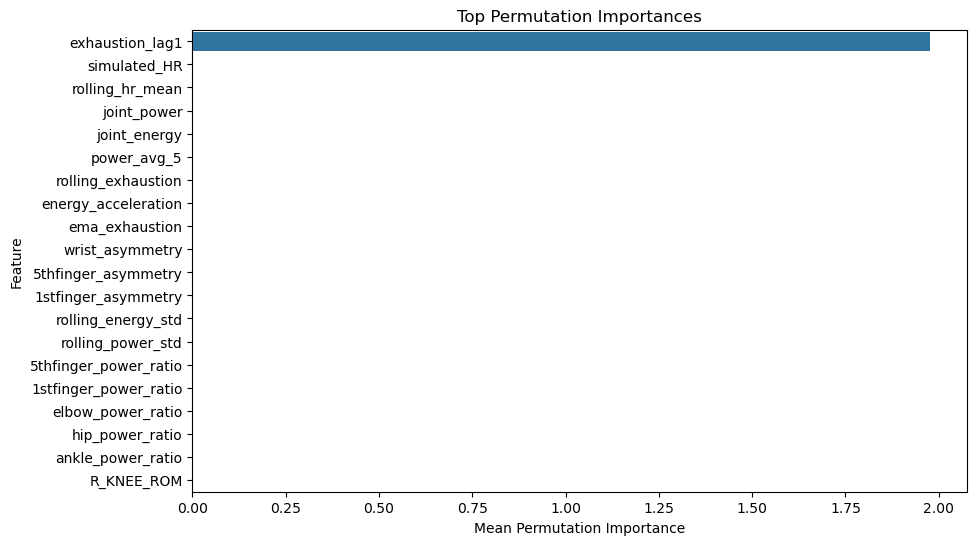

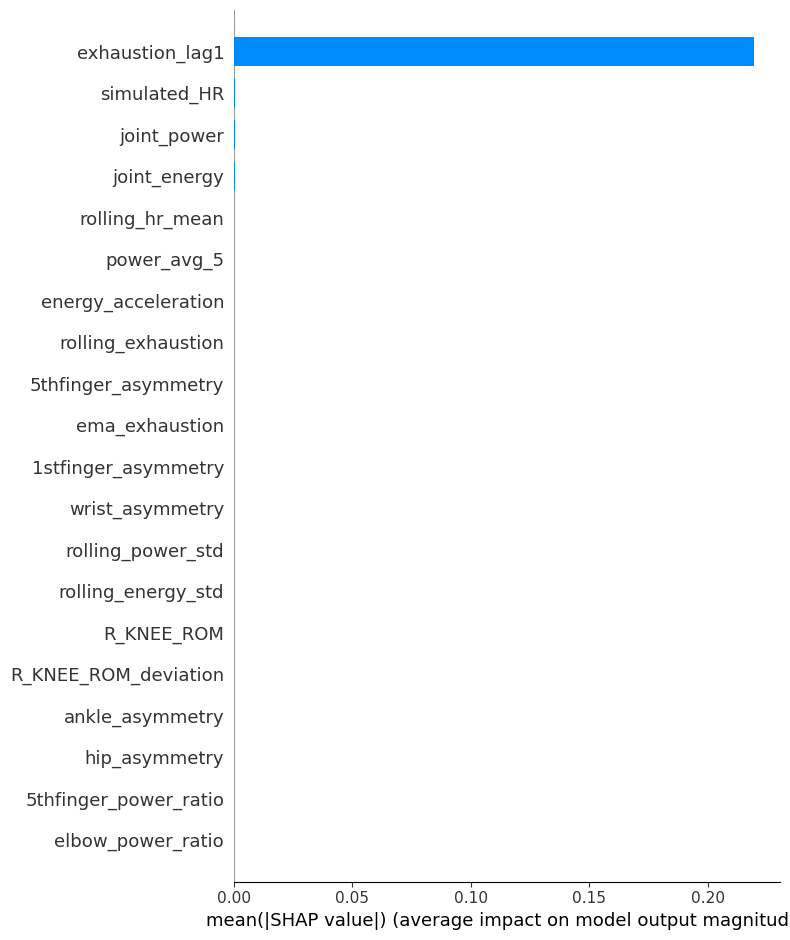

C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data[features].fillna(method='ffill').fillna(method='bfill')
C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = data[target].fillna(method='ffill').fillna(method='bfill')


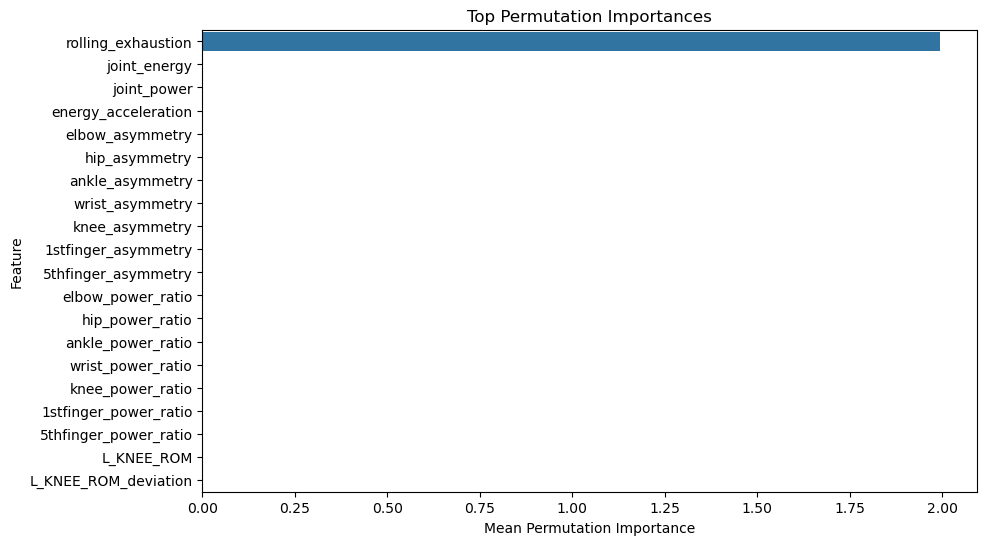

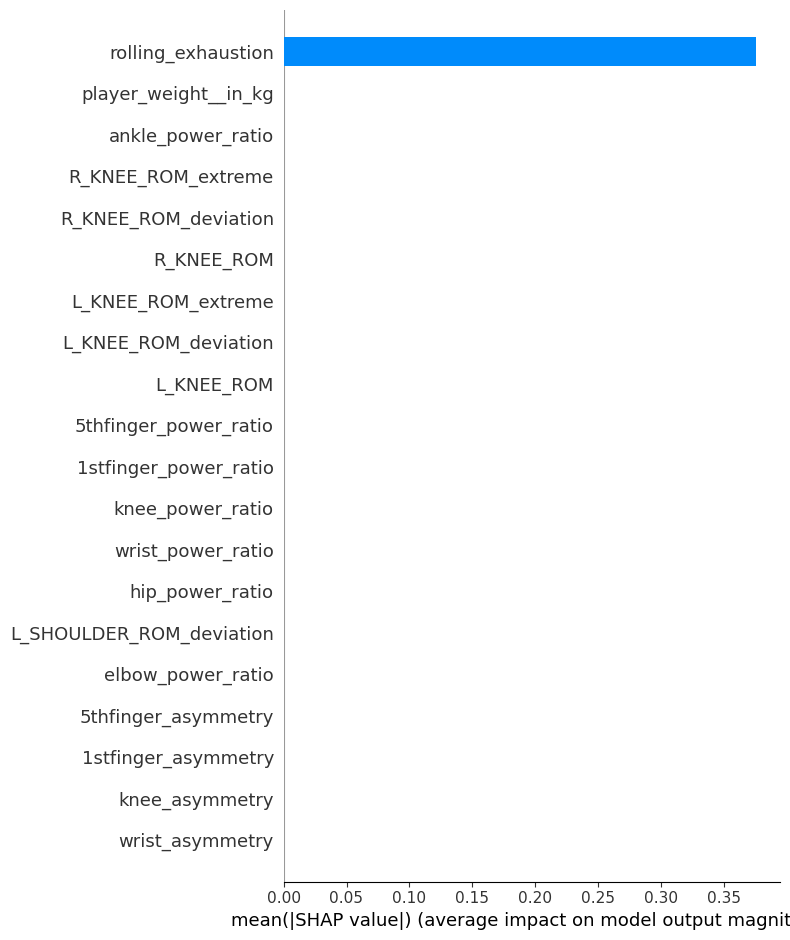

C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data[features].fillna(method='ffill').fillna(method='bfill')
C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = data[target].fillna(method='ffill').fillna(method='bfill')


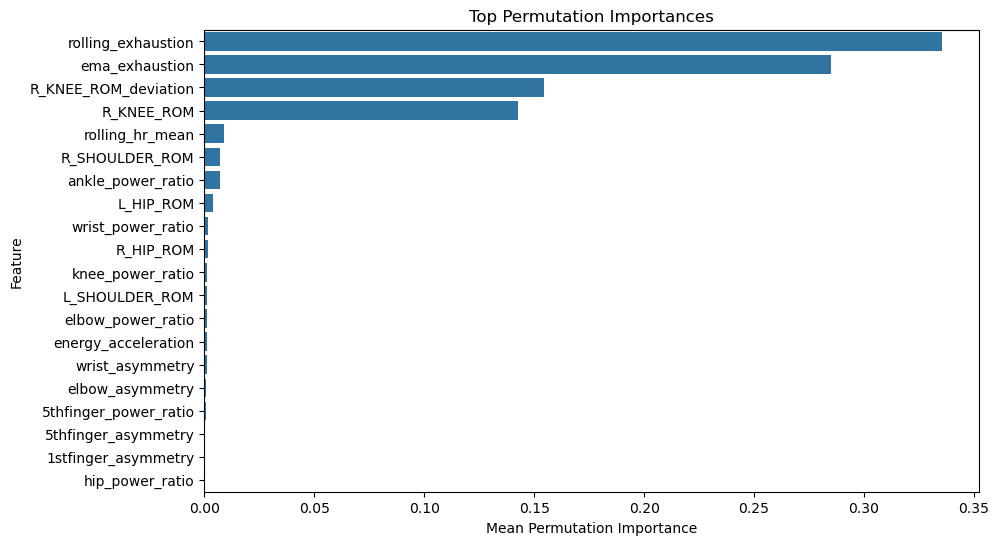

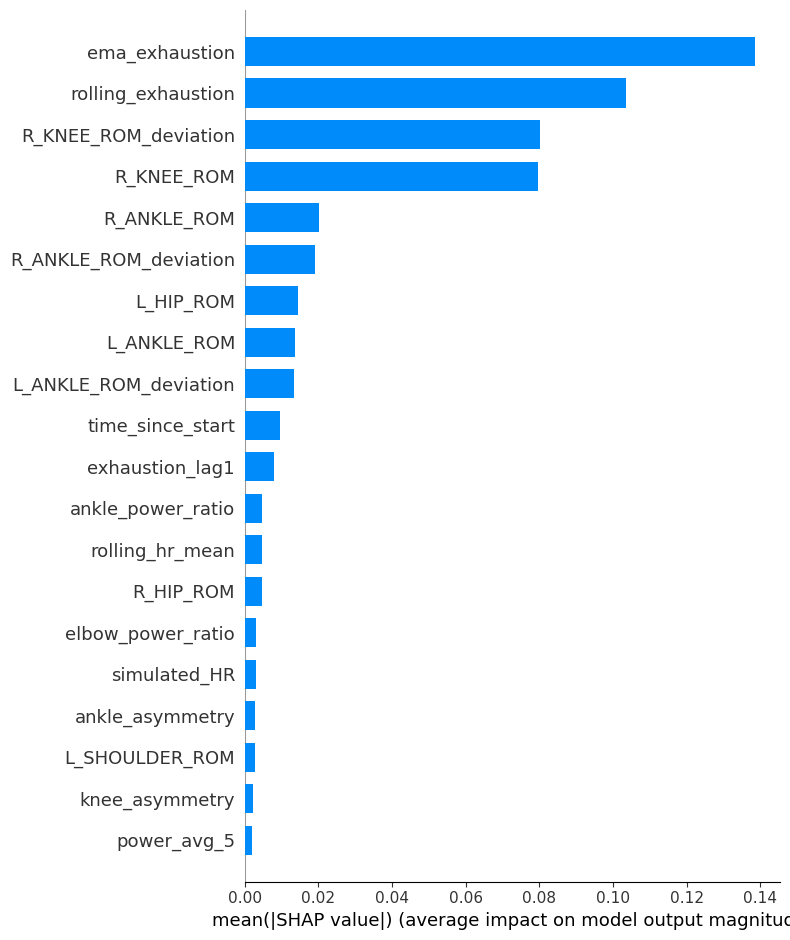

C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data[features].fillna(method='ffill').fillna(method='bfill')
C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = data[target].fillna(method='ffill').fillna(method='bfill')


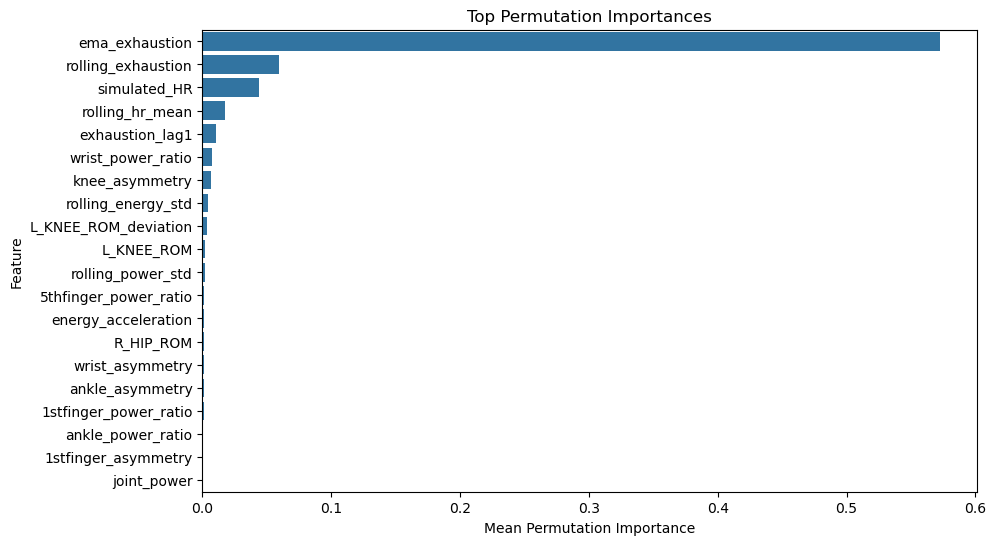

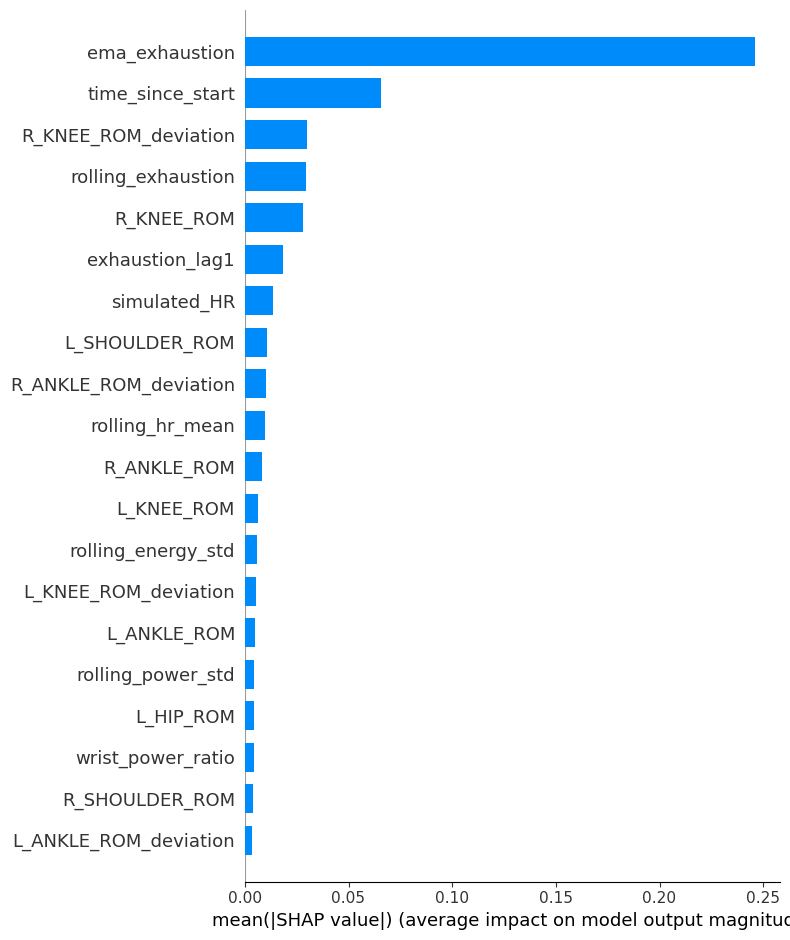

C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data[features].fillna(method='ffill').fillna(method='bfill')
C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = data[target].fillna(method='ffill').fillna(method='bfill')


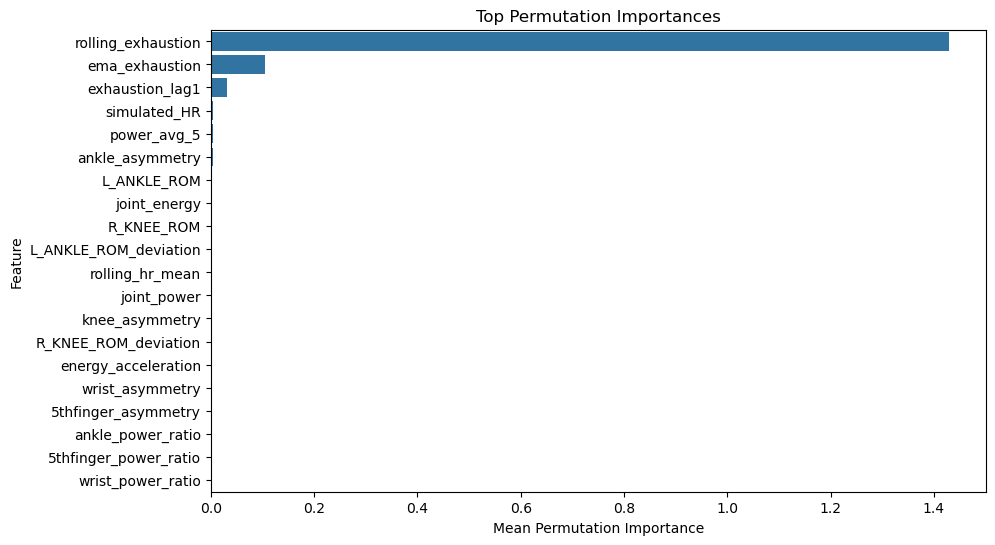

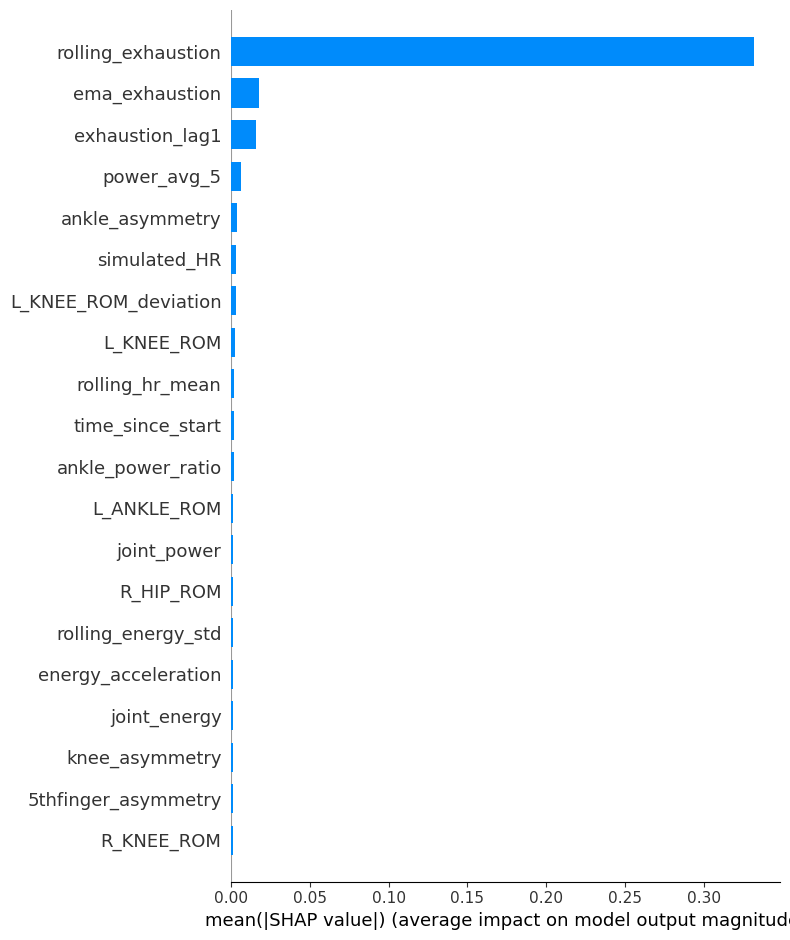

C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data[features].fillna(method='ffill').fillna(method='bfill')
C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = data[target].fillna(method='ffill').fillna(method='bfill')


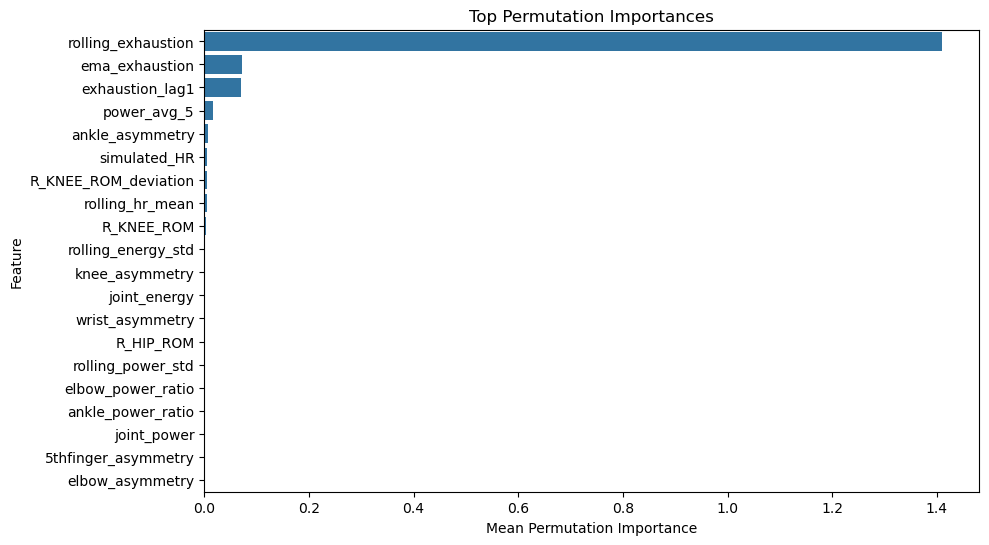

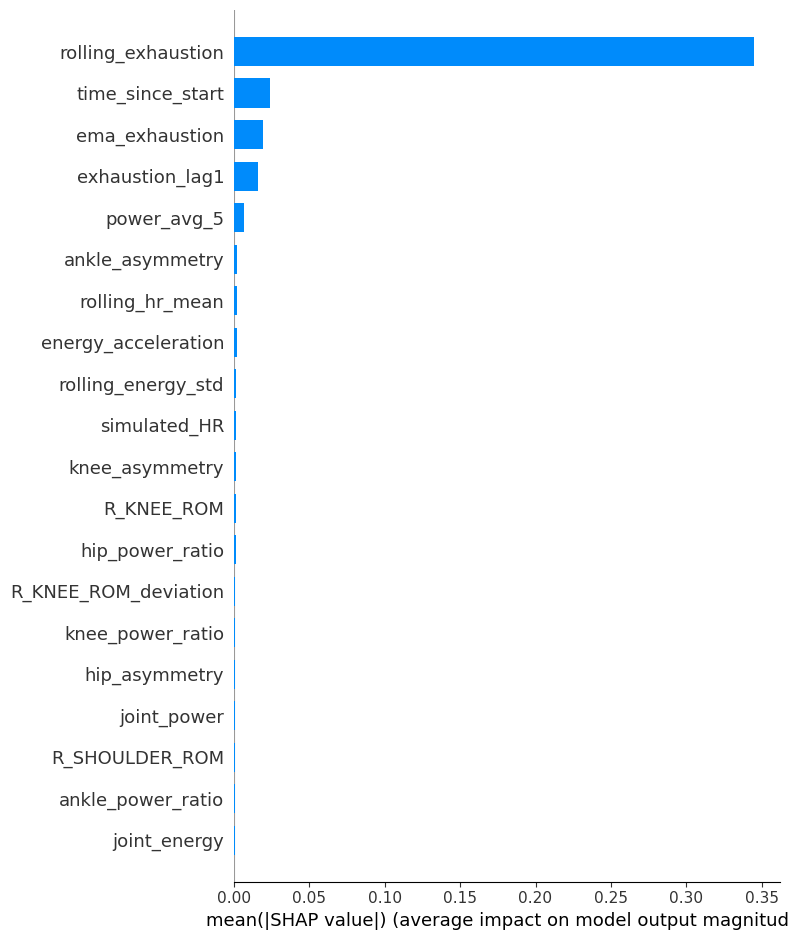

C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data[features].fillna(method='ffill').fillna(method='bfill')
C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = data[target].fillna(method='ffill').fillna(method='bfill')


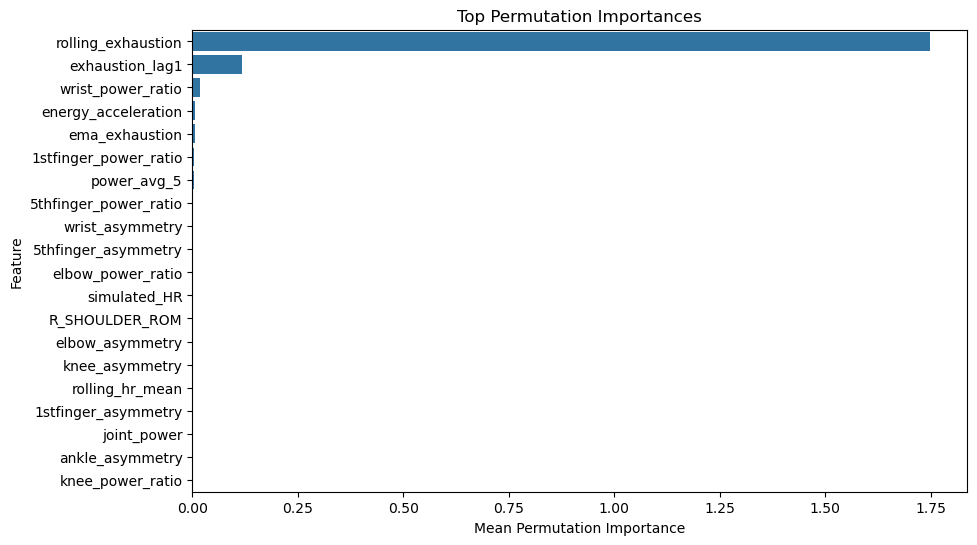

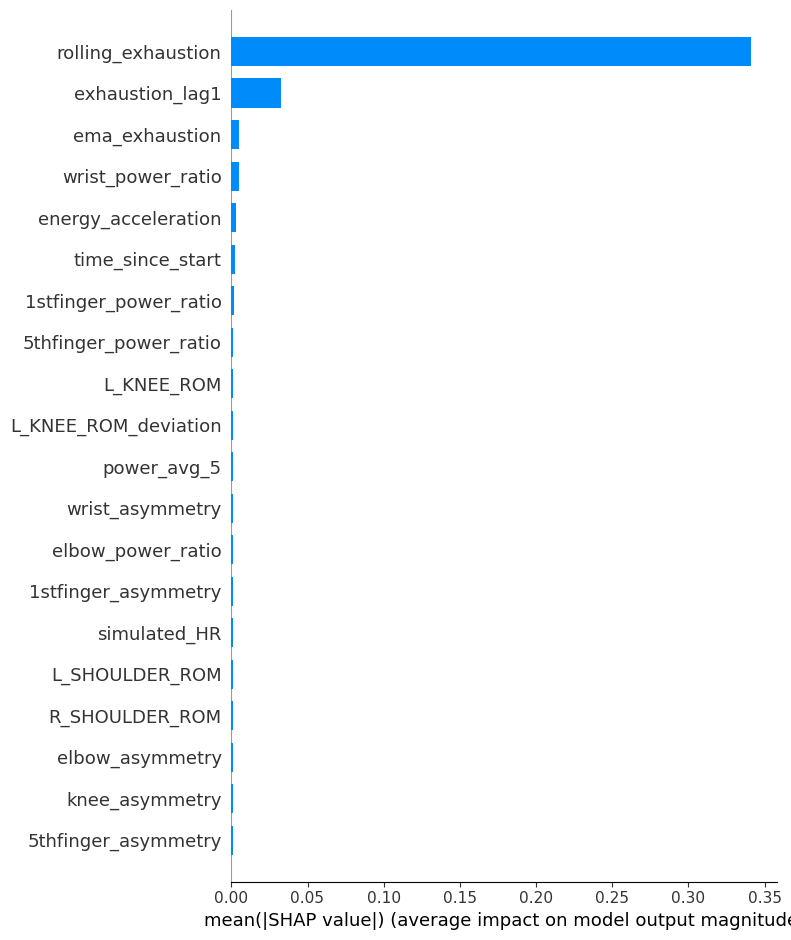

C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data[features].fillna(method='ffill').fillna(method='bfill')
C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = data[target].fillna(method='ffill').fillna(method='bfill')


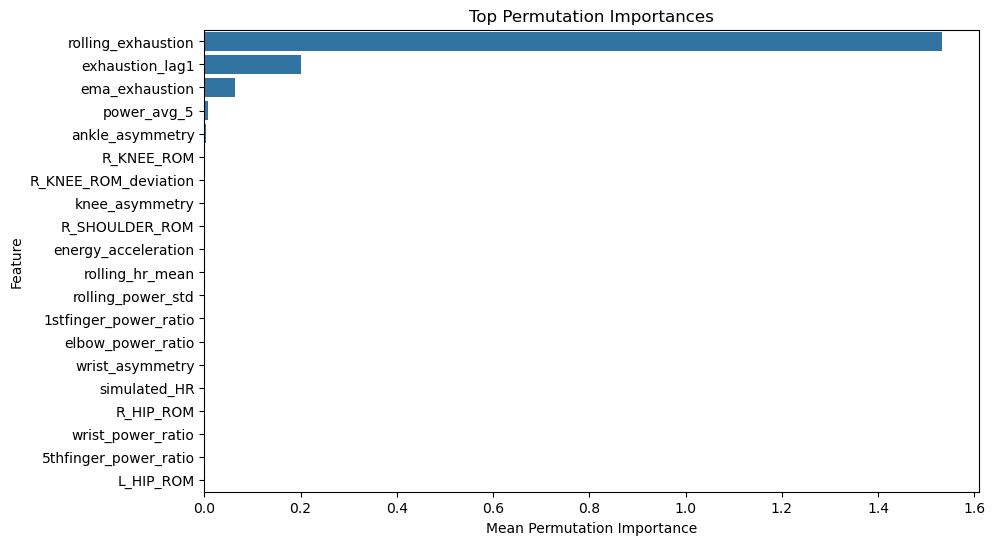

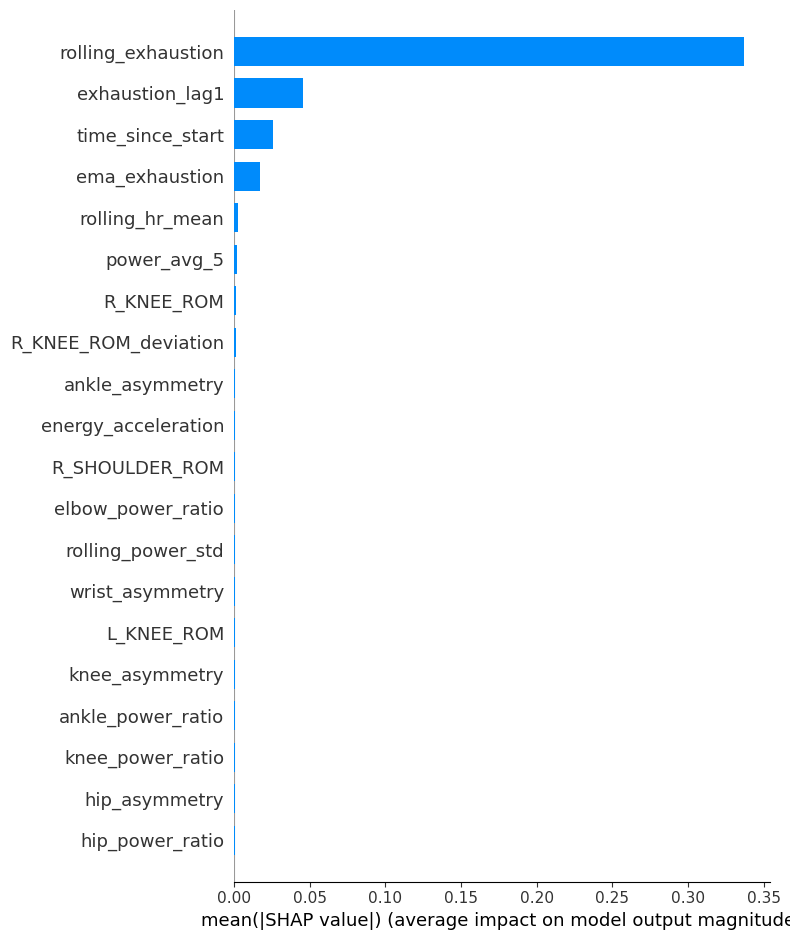

C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data[features].fillna(method='ffill').fillna(method='bfill')
C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = data[target].fillna(method='ffill').fillna(method='bfill')


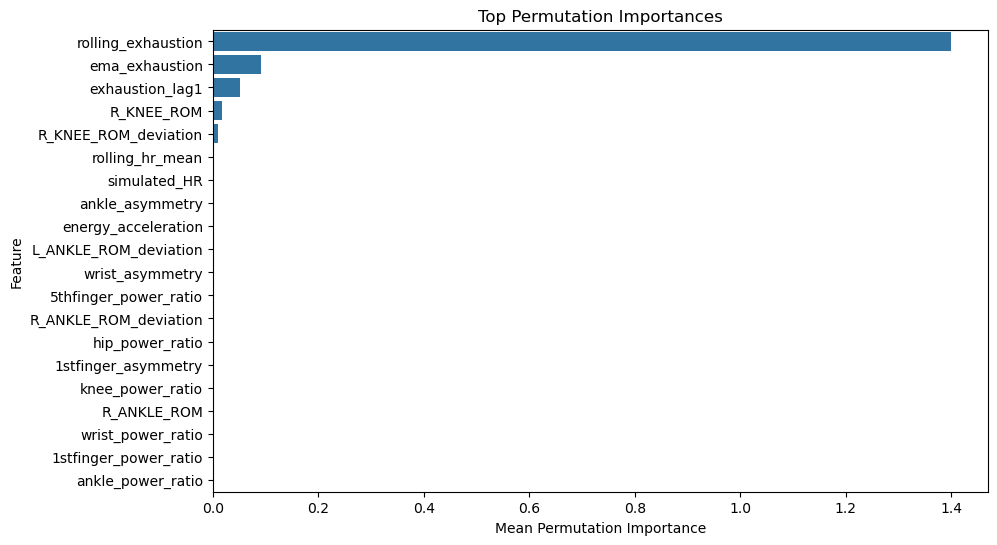

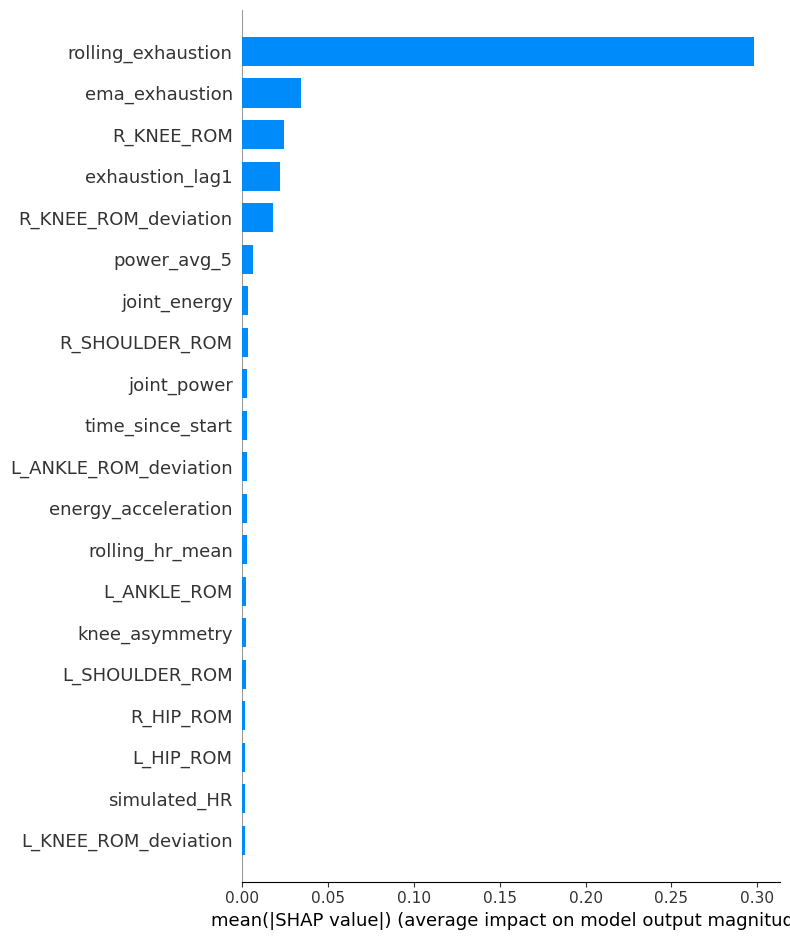

C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data[features].fillna(method='ffill').fillna(method='bfill')
C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = data[target].fillna(method='ffill').fillna(method='bfill')


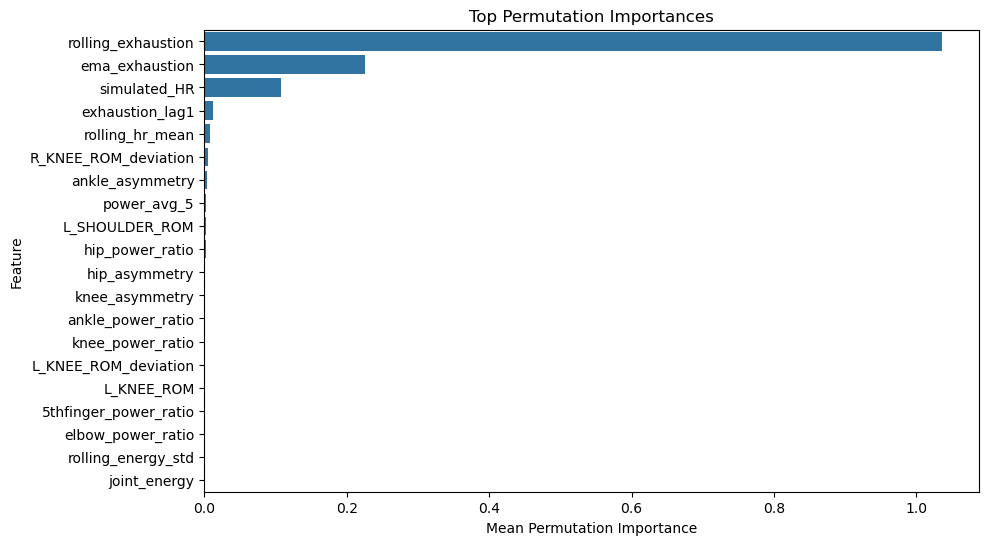

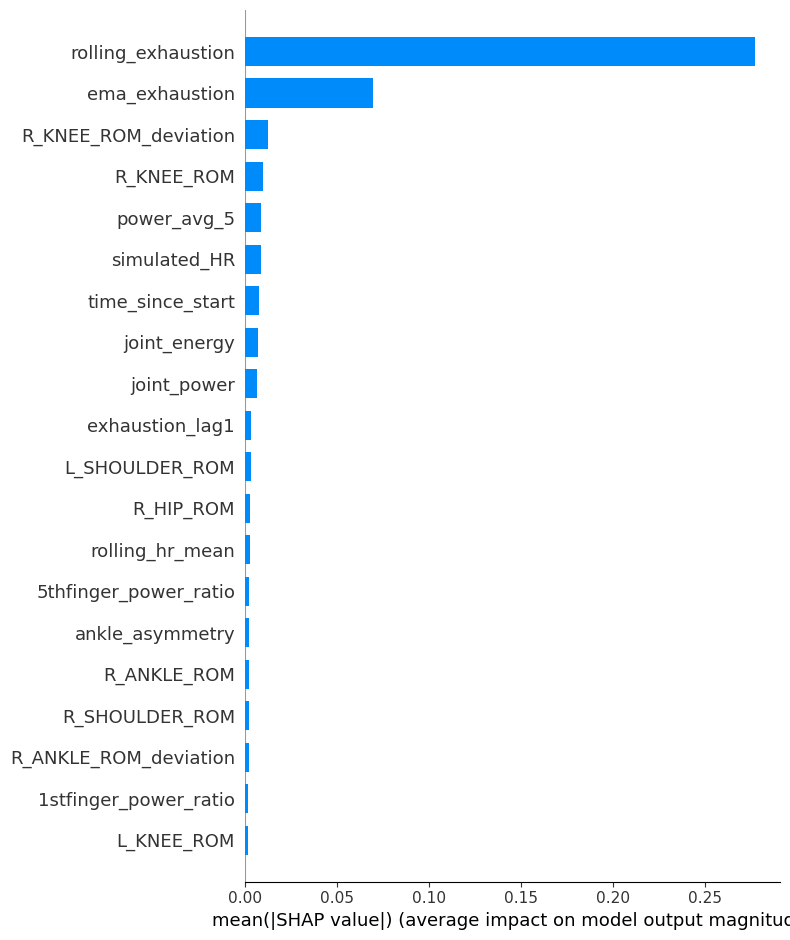

C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data[features].fillna(method='ffill').fillna(method='bfill')
C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = data[target].fillna(method='ffill').fillna(method='bfill')


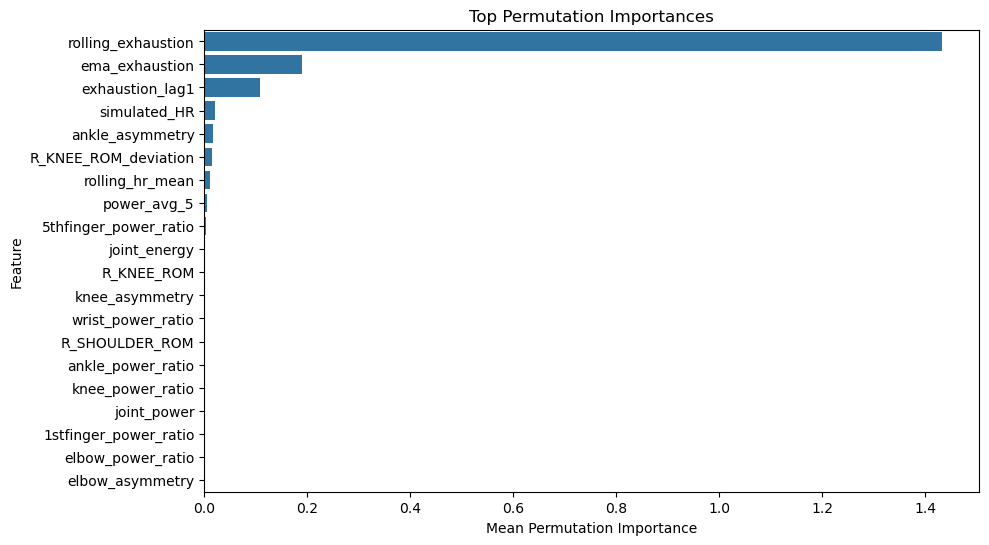

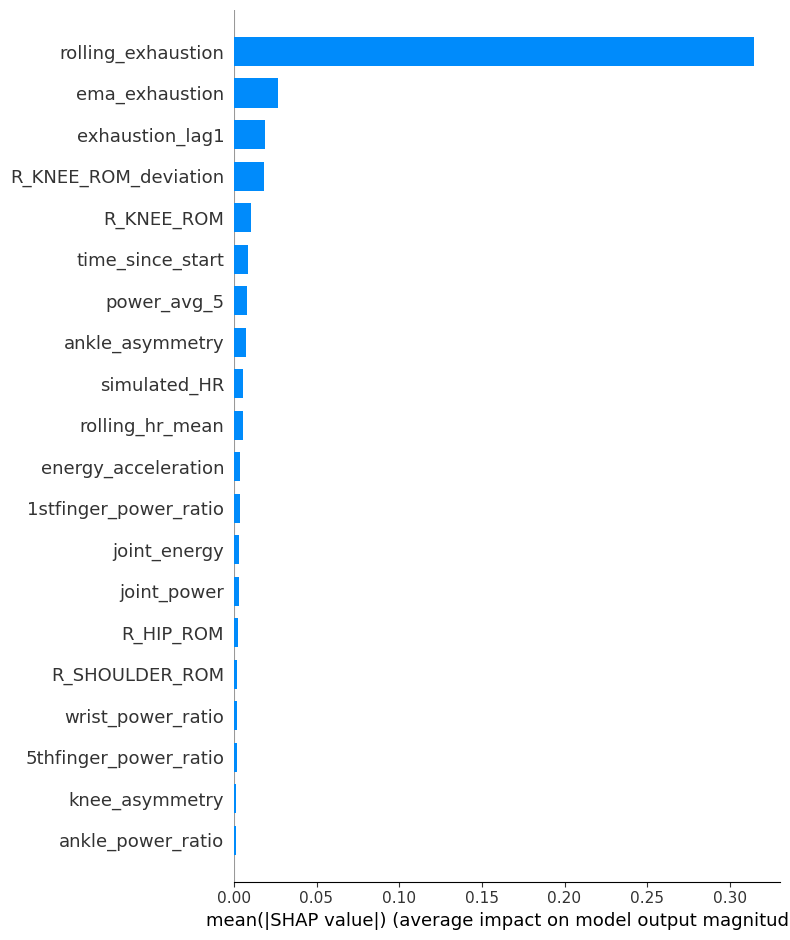

C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data[features].fillna(method='ffill').fillna(method='bfill')
C:\Users\ghadf\AppData\Local\Temp\ipykernel_31240\1211132508.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = data[target].fillna(method='ffill').fillna(method='bfill')


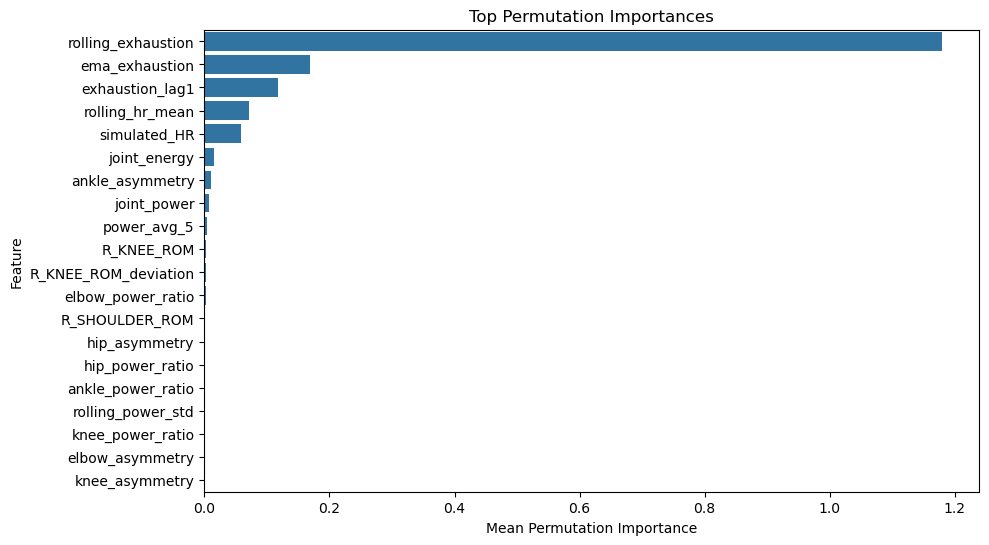

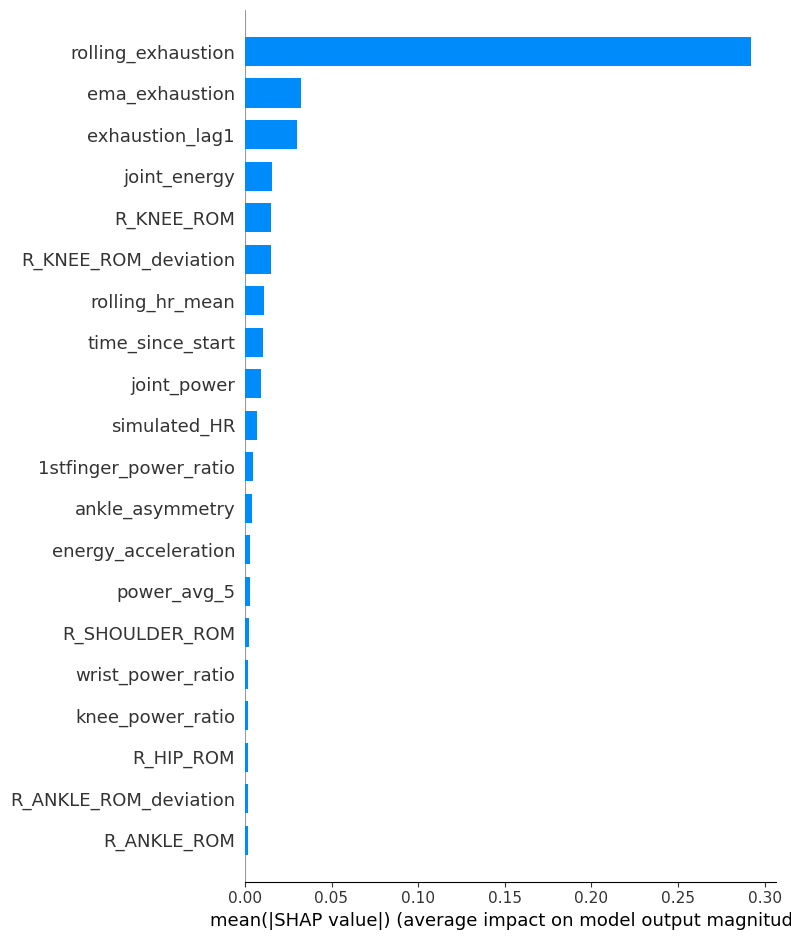


=== Feature Analysis for Target: BY_TRIAL_EXHAUSTION_SCORE ===
Permutation Top 5: ['exhaustion_lag1', 'simulated_HR', 'rolling_hr_mean', 'joint_power', 'joint_energy']
RFE Selected Features: ['joint_energy', 'wrist_asymmetry', 'exhaustion_lag1', 'rolling_hr_mean', 'simulated_HR']
SHAP Top 5: ['exhaustion_lag1', 'simulated_HR', 'joint_power', 'joint_energy', 'rolling_hr_mean']
Consensus Top 5: ['exhaustion_lag1', 'simulated_HR', 'joint_power', 'rolling_hr_mean', 'joint_energy']

=== Feature Analysis for Target: INJURY_RISK ===
Permutation Top 5: ['rolling_exhaustion', 'joint_energy', 'joint_power', 'energy_acceleration', 'elbow_asymmetry']
RFE Selected Features: ['rolling_exhaustion', 'rolling_energy_std', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']
SHAP Top 5: ['rolling_exhaustion', 'joint_energy', 'joint_power', 'energy_acceleration', 'elbow_asymmetry']
Consensus Top 5: ['rolling_exhaustion', 'rolling_energy_std', 'simulated_HR', 'player_height_in_meters', 'pla

In [45]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import sys
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


def perform_feature_importance_analysis(data, features, target, n_features_to_select=5, debug=False):
    """
    Performs feature importance analysis using Permutation Importance, RFE, and SHAP.
    
    Steps:
      1. Prepares the data (fills missing values and splits into training/testing sets).
      2. Trains a RandomForestRegressor.
      3. Computes Permutation Importance.
      4. Performs Recursive Feature Elimination (RFE) on training data.
      5. Merges the results into one combined DataFrame.
      6. Computes SHAP values and integrates the mean absolute SHAP importance into the combined DataFrame.
      7. Optionally produces debug plots if debug=True.
    
    Returns:
      - combined (pd.DataFrame): DataFrame with permutation importance, RFE rankings, and SHAP importance.
      - rf (RandomForestRegressor): The fitted model.
    """
    # Prepare X and y by filling missing values
    X = data[features].fillna(method='ffill').fillna(method='bfill')
    y = data[target].fillna(method='ffill').fillna(method='bfill')
    
    # Preserve temporal order for splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Train RandomForestRegressor on training data
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # 1. Permutation Importance
    perm_result = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42)
    perm_df = pd.DataFrame({
        'Feature': features,
        'Perm_Importance': perm_result.importances_mean
    })
    
    # 2. Recursive Feature Elimination (RFE)
    rfe_selector = RFE(estimator=rf, n_features_to_select=n_features_to_select, step=1)
    rfe_selector.fit(X_train, y_train)
    rfe_df = pd.DataFrame({
        'Feature': features,
        'RFE_Rank': rfe_selector.ranking_,
        'RFE_Support': rfe_selector.support_
    })
    
    # Combine Permutation Importance and RFE results
    combined = perm_df.merge(rfe_df, on='Feature')
    
    # 3. SHAP Analysis: compute SHAP values and integrate into the combined DataFrame
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_test)
    # Compute the mean absolute SHAP value for each feature
    shap_abs = np.abs(shap_values).mean(axis=0)
    shap_df = pd.DataFrame({
        'Feature': features,
        'SHAP_Importance': shap_abs
    })
    # Merge the SHAP importance with the combined DataFrame
    combined = combined.merge(shap_df, on='Feature')
    
    # Conditional visualization based on the debug flag
    if debug:
        # Permutation Importance Plot
        plt.figure(figsize=(10,6))
        sns.barplot(x='Perm_Importance', y='Feature', data=combined.nlargest(20, 'Perm_Importance'))
        plt.title('Top Permutation Importances')
        plt.xlabel('Mean Permutation Importance')
        plt.ylabel('Feature')
        plt.show()

        # SHAP Summary Plot (Bar type)
        shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)
        
    # Return only the combined metrics and the model to simplify output
    return combined, rf


def analyze_and_display_top_features(results, n_top=5):
    """
    For each target in the results dictionary, extracts and displays the top features based on:
      - Permutation Importance
      - RFE (only the features selected by RFE support)
      - SHAP Importance
      - A consensus ranking calculated from the three metrics.
    
    Parameters:
      - results (dict): A dictionary where keys are target names and values are tuples:
                          (combined DataFrame, fitted model).
      - n_top (int): Number of top features to display for each method.
    
    This function prints the top features for each target.
    """
    for target, (combined, _) in results.items():
        print(f"\n=== Feature Analysis for Target: {target.upper()} ===")
        
        # Extract top features based on Permutation Importance (largest values)
        perm_top = combined.nlargest(n_top, 'Perm_Importance')['Feature'].tolist()
        
        # Extract features selected by RFE (where RFE_Support is True)
        rfe_top = combined[combined['RFE_Support']]['Feature'].tolist()
        
        # Extract top features based on SHAP Importance (largest values)
        shap_top = combined.nlargest(n_top, 'SHAP_Importance')['Feature'].tolist()
        
        # Calculate a consensus ranking:
        # For permutation and SHAP, we use descending order rankings;
        # For RFE, the lower the ranking the better.
        combined['Consensus_Rank'] = (
            combined['Perm_Importance'].rank(ascending=False) +
            combined['RFE_Rank'] +
            combined['SHAP_Importance'].rank(ascending=False)
        )
        consensus_top = combined.nsmallest(n_top, 'Consensus_Rank')['Feature'].tolist()
        
        # Display the results
        print(f"Permutation Top {n_top}: {perm_top}")
        print(f"RFE Selected Features: {rfe_top}")
        print(f"SHAP Top {n_top}: {shap_top}")
        print(f"Consensus Top {n_top}: {consensus_top}")
        
        
if __name__ == "__main__":
    debug = True
    csv_path = "../../data/processed/final_granular_dataset.csv"
    json_path = "../../data/basketball/freethrow/participant_information.json"
    
    # Load and process the data.
    data = load_data(csv_path, json_path, debug=debug)
    data = prepare_joint_features(data, debug=debug)
    data = feature_engineering(data, debug=debug)
    print(data.columns.tolist())
    
    # Define your complete features list (as updated previously)
    features = [
        # Aggregated metrics:
        'joint_energy', 'joint_power', 'energy_acceleration',
        # Asymmetry metrics:
        'elbow_asymmetry', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry',
        # Power ratios:
        'elbow_power_ratio', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio',
        # ROM metrics (side-specific):
        'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme',
        'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme',
        'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme',
        'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme',
        'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme',
        'R_HIP_ROM', 'R_HIP_ROM_deviation', 'R_HIP_ROM_extreme',
        'L_ANKLE_ROM', 'L_ANKLE_ROM_deviation', 'L_ANKLE_ROM_extreme',
        'R_ANKLE_ROM', 'R_ANKLE_ROM_deviation', 'R_ANKLE_ROM_extreme',
        # Lagged and rolling features:
        'exhaustion_lag1', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'time_since_start', 'ema_exhaustion', 'rolling_exhaustion', 'rolling_energy_std',
        'simulated_HR',
        # Anthropometrics:
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    # Define a list of target variables.
    # Start with overall exhaustion and overall injury risk.
    targets = ['by_trial_exhaustion_score', 'injury_risk']
    
    # Now, add joint-specific injury risk targets.
    # (Assuming your joint-specific feature engineering has created columns such as 'L_ANKLE_injury_risk', 'R_ANKLE_injury_risk', etc.)
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    for joint in joints:
        for side in ['L', 'R']:
            target_col = f"{side}_{joint}_injury_risk"
            targets.append(target_col)
    
    # Verify that all features and targets exist in the data.
    missing_features = [feat for feat in features if feat not in data.columns]
    missing_targets = [t for t in targets if t not in data.columns]
    if missing_features:
        logging.error(f"Missing features: {missing_features}")
        sys.exit(1)
    if missing_targets:
        logging.error(f"Missing target variables: {missing_targets}")
        sys.exit(1)
    else:
        logging.info("All required features and target variables are present.")
    
    # Perform feature importance analysis for each target.
    results = {}
    for target in targets:
        combined, model = perform_feature_importance_analysis(data, features, target, debug=True)
        results[target] = (combined, model)
    
    analyze_and_display_top_features(results)



# Preprocessing and Split (ensure that the preprocessing is correctly occuring to the right)

In [ ]:
import numpy as np
import pandas as pd
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import sys


def temporal_train_test_split(data, test_size=0.2):
    """Time-based split maintaining temporal order"""
    split_idx = int(len(data) * (1 - test_size))
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]
    logging.info(f"Performed temporal train-test split with test size = {test_size}")
    logging.info(f"Training data shape: {train_data.shape}, Testing data shape: {test_data.shape}")
    return train_data, test_data


def scale_features(X_train, X_test):
    """
    Scales features using StandardScaler.

    Parameters:
    - X_train (np.array): Training features.
    - X_test (np.array): Testing features.

    Returns:
    - X_train_scaled (np.array): Scaled training features.
    - X_test_scaled (np.array): Scaled testing features.
    - scaler (StandardScaler): Fitted scaler object.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    logging.info("Features have been scaled using StandardScaler.")
    return X_train_scaled, X_test_scaled, scaler

def create_sequences(X, y, timesteps):
    """
    Creates sequences of data for LSTM input.

    Parameters:
    - X (np.array): Features array.
    - y (np.array): Target array.
    - timesteps (int): Number of past trials to consider.

    Returns:
    - X_seq (np.array): Sequence features.
    - y_seq (np.array): Corresponding targets.
    """
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])
        y_seq.append(y[i])
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    logging.info(f"Created LSTM sequences: {X_seq.shape}, {y_seq.shape}")
    return X_seq, y_seq




if __name__ == "__main__":
    # Paths to data files
    csv_path = "../data/processed/final_granular_dataset.csv"
    json_path = "../data/basketball/freethrow/participant_information.json"
    
    # Load and merge data
    data = load_data(csv_path, json_path)
    
    # Prepare joint features and additional engineered features
    data = prepare_joint_features(data)
    data = feature_engineering(data)
    
    # Define features and targets
    features_exhaustion = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  # Updated from 'elbow_angle' to 'elbow_asymmetry'
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_exhaustion = 'by_trial_exhaustion_score'
    
    features_injury = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  # Updated from 'elbow_angle' to 'elbow_asymmetry'
        'knee_asymmetry', 
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_injury = 'injury_risk'
    
    # Verify all features exist in the DataFrame
    missing_features = [
        feature for feature in features_exhaustion + features_injury 
        if feature not in data.columns
    ]
    if missing_features:
        logging.error(f"Missing features detected: {missing_features}")
        logging.error("Please ensure all required features are present in the dataset.")
        sys.exit(1)
    else:
        logging.info("All required features are present.")
    
    # Split data into training and testing sets based on time
    # Unified temporal split
    train_data, test_data = temporal_train_test_split(data)
    train_exhaustion = train_data.copy()
    test_exhaustion = test_data.copy()
    train_injury = train_data.copy()
    test_injury = test_data.copy()
    
    # Extract features and targets for exhaustion prediction
    X_train_exhaustion = train_exhaustion[features_exhaustion].values
    y_train_exhaustion = train_exhaustion[target_exhaustion].values
    X_test_exhaustion = test_exhaustion[features_exhaustion].values
    y_test_exhaustion = test_exhaustion[target_exhaustion].values
    
    # Extract features and targets for injury risk prediction
    X_train_injury = train_injury[features_injury].values
    y_train_injury = train_injury[target_injury].values
    X_test_injury = test_injury[features_injury].values
    y_test_injury = test_injury[target_injury].values
    
    # Scale features
    X_train_exhaustion_scaled, X_test_exhaustion_scaled, scaler_exhaustion = scale_features(X_train_exhaustion, X_test_exhaustion)
    X_train_injury_scaled, X_test_injury_scaled, scaler_injury = scale_features(X_train_injury, X_test_injury)
    
    # Define number of timesteps for LSTM
    timesteps = 5
    
    # Create sequences for LSTM
    X_lstm_exhaustion, y_lstm_exhaustion = create_sequences(X_train_exhaustion_scaled, y_train_exhaustion, timesteps)
    X_lstm_exhaustion_val, y_lstm_exhaustion_val = create_sequences(X_test_exhaustion_scaled, y_test_exhaustion, timesteps)
    
    X_lstm_injury, y_lstm_injury = create_sequences(X_train_injury_scaled, y_train_injury, timesteps)
    X_lstm_injury_val, y_lstm_injury_val = create_sequences(X_test_injury_scaled, y_test_injury, timesteps)
    

INFO: Loaded data from ../data/processed/final_granular_dataset.csv with shape (16047, 214)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 217)
INFO: Step [load_data] completed.
INFO: Renamed participant anthropometrics.
INFO: Identified 15 joint energy and 14 joint power columns.
INFO: Created aggregated 'joint_energy' and 'joint_power'.
INFO: Created 'energy_acceleration' feature as derivative of joint_energy over time.
INFO: Created 'ankle_power_ratio' feature comparing left to right ankle ongoing power.
INFO: Sorted data by 'participant_id' and 'continuous_frame_time'.
INFO: Created asymmetry features.
INFO: Created 'exhaustion_rate' feature.
INFO: Created 'simulated_HR' feature.
INFO: Step [prepare_joint_features] completed.
INFO: Created 'exhaustion_lag1' feature.
INFO: Created 'power_avg_5' feature.
INFO: Created 'rolling_p

# Build Model and Train

INFO: Loaded data from ../data/processed/final_granular_dataset.csv with shape (16047, 214)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 217)
INFO: Step [load_data] completed.
INFO: Renamed participant anthropometrics.
INFO: Identified 15 joint energy and 14 joint power columns.
INFO: Created aggregated 'joint_energy' and 'joint_power'.
INFO: Created 'energy_acceleration' feature as derivative of joint_energy over time.
INFO: Created 'ankle_power_ratio' feature comparing left to right ankle ongoing power.
INFO: Sorted data by 'participant_id' and 'continuous_frame_time'.
INFO: Created asymmetry features.
INFO: Created 'exhaustion_rate' feature.
INFO: Created 'simulated_HR' feature.
INFO: Step [prepare_joint_features] completed.
INFO: Created 'exhaustion_lag1' feature.
INFO: Created 'power_avg_5' feature.
INFO: Created 'rolling_p

Epoch 1/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0450 - mae: 0.1330 - val_loss: 0.0097 - val_mae: 0.0479
Epoch 2/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0082 - mae: 0.0473 - val_loss: 0.0059 - val_mae: 0.0277
Epoch 3/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0069 - mae: 0.0389 - val_loss: 0.0059 - val_mae: 0.0265
Epoch 4/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0056 - mae: 0.0337 - val_loss: 0.0065 - val_mae: 0.0242
Epoch 5/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0057 - mae: 0.0318 - val_loss: 0.0063 - val_mae: 0.0295
Epoch 6/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0049 - mae: 0.0297 - val_loss: 0.0056 - val_mae: 0.0228
Epoch 7/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0049 - mae: 0.0282 - val_loss: 0.0063 - val_mae: 0.0228
Epoch 8/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0051 - mae: 0.0294 - val_loss: 0.0062 - val_mae: 0.0261
Epoch 9/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/

INFO: Trained model with Early Stopping for up to 100 epochs and batch size 32.
INFO: Built classification LSTM model with Dropout layers.


Epoch 1/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9423 - loss: 0.2081 - val_accuracy: 0.9798 - val_loss: 0.0625
Epoch 2/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9799 - loss: 0.0610 - val_accuracy: 0.9846 - val_loss: 0.0427
Epoch 3/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9799 - loss: 0.0528 - val_accuracy: 0.9748 - val_loss: 0.0528
Epoch 4/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9817 - loss: 0.0470 - val_accuracy: 0.9846 - val_loss: 0.0362
Epoch 5/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9838 - loss: 0.0392 - val_accuracy: 0.9761 - val_loss: 0.0632
Epoch 6/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9838 - loss: 0.0420 - val_accuracy: 0.9836 - val_loss: 0.0364
Epoch 7/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9850 - loss: 0.0359 - val_accuracy: 0.9874 - val_loss: 0.0314
Epoch 8/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9840 - loss: 0.0355 - val_accu

INFO: Trained model with Early Stopping for up to 100 epochs and batch size 32.


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


INFO: Regression Model Evaluation - MAE: 0.022792827997819436, R²: 0.9214541410984611
INFO: Classification Model Evaluation - Accuracy: 0.996536523929471, Precision: 0.9880952380952381, Recall: 0.9987966305655837, F1-Score: 0.9934171154997008, ROC-AUC: 0.9999661311800975


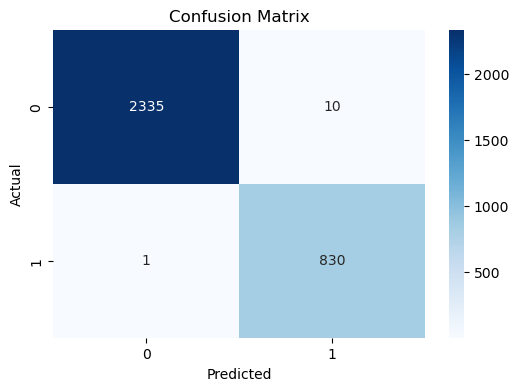

INFO: 
--- Evaluation Results ---
INFO: Exhaustion Prediction - MAE: 0.022792827997819436, R²: 0.9214541410984611
INFO: Injury Risk Prediction - Accuracy: 0.996536523929471, Precision: 0.9880952380952381, Recall: 0.9987966305655837, F1-Score: 0.9934171154997008, ROC-AUC: 0.9999661311800975


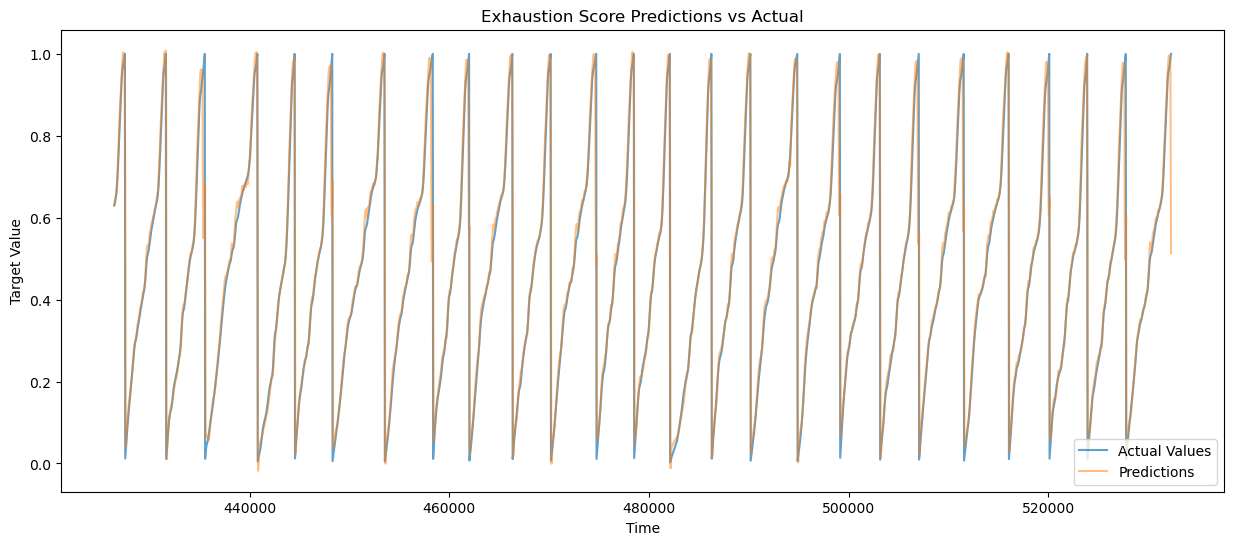

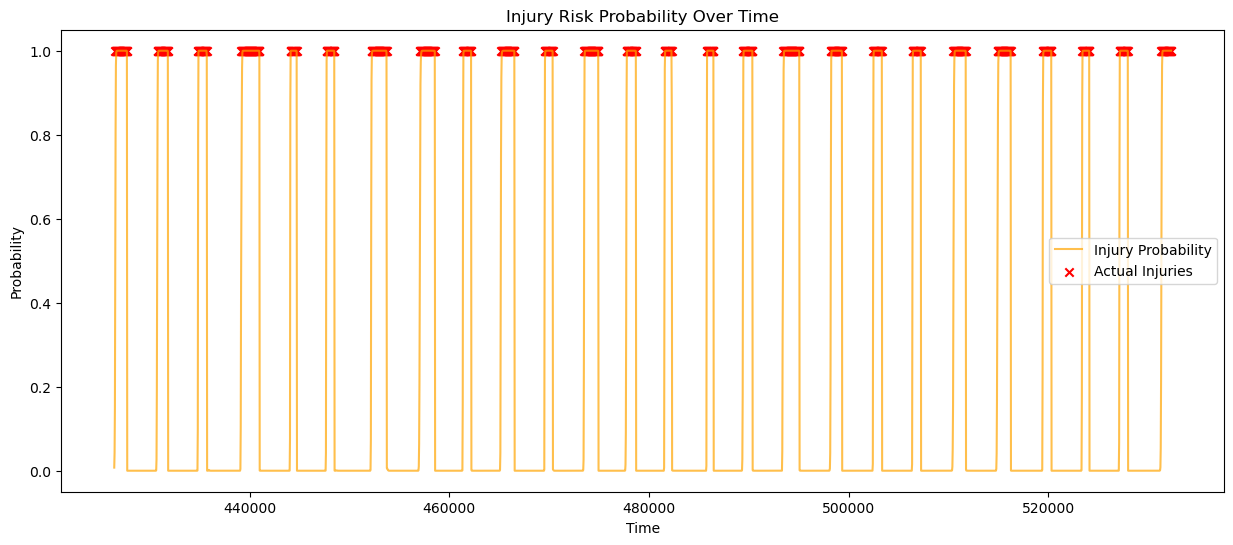

In [ ]:


def build_enhanced_lstm(input_shape, target_type='regression'):
    """
    Builds and compiles an enhanced LSTM model with regularization.
    
    Parameters:
    - input_shape (tuple): (timesteps, num_features)
    - target_type (str): 'regression' or 'classification' to set final layer.
    
    Returns:
    - model (Sequential): Compiled LSTM model.
    """
    model = Sequential()
    # First LSTM layer with Dropout
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    # Second LSTM layer with Dropout
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    # Dense hidden layer
    model.add(Dense(32, activation='relu'))
    
    if target_type == 'classification':
        # Output layer for binary classification
        model.add(Dense(1, activation='sigmoid'))
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
    else:
        # Output layer for regression
        model.add(Dense(1, activation='linear'))
        model.compile(
            optimizer='adam',
            loss='mse',
            metrics=['mae']
        )
    
    logging.info(f"Built {'classification' if target_type == 'classification' else 'regression'} LSTM model with Dropout layers.")
    return model

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    """
    Trains the LSTM model with Early Stopping.
    
    Parameters:
    - model (Sequential): Compiled LSTM model.
    - X_train (np.array): Training features.
    - y_train (np.array): Training targets.
    - X_val (np.array): Validation features.
    - y_val (np.array): Validation targets.
    - epochs (int): Number of training epochs.
    - batch_size (int): Batch size.
    
    Returns:
    - history: Training history object.
    """
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )
    history = model.fit(
        X_train, 
        y_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=1
    )
    logging.info(f"Trained model with Early Stopping for up to {epochs} epochs and batch size {batch_size}.")
    return history

def evaluate_model_regression(y_true, y_pred):
    """
    Evaluates regression model performance.

    Parameters:
    - y_true (np.array): True target values.
    - y_pred (np.array): Predicted target values.

    Returns:
    - metrics (dict): Dictionary containing MAE and R².
    """
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    logging.info(f"Regression Model Evaluation - MAE: {mae}, R²: {r2}")
    return {'MAE': mae, 'R2': r2}

def evaluate_model_classification(y_true, y_pred):
    """
    Evaluates classification model performance with comprehensive metrics.
    
    Parameters:
    - y_true (np.array): True target values.
    - y_pred (np.array): Predicted target values (probabilities).
    
    Returns:
    - metrics (dict): Dictionary containing Accuracy, Precision, Recall, F1-Score, ROC-AUC.
    """
    y_pred_binary = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }
    
    logging.info(f"Classification Model Evaluation - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, ROC-AUC: {roc_auc}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return metrics

def plot_predictions(true_values, predictions, model_name, timesteps, time_indices):
    """
    Plots actual vs. predicted values over time.
    
    Parameters:
    - true_values (np.array): Actual target values.
    - predictions (np.array): Predicted target values.
    - model_name (str): Name of the model (for title purposes).
    - timesteps (int): Number of timesteps used in sequences.
    - time_indices (np.array): Array of time indices corresponding to the data.
    """
    plt.figure(figsize=(15, 6))
    adj_time = time_indices[timesteps:]
    plt.plot(adj_time, true_values, label='Actual Values', alpha=0.7)
    plt.plot(adj_time, predictions, label='Predictions', alpha=0.5)
    plt.title(f'{model_name} Predictions vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.legend()
    plt.show()

def plot_injury_probabilities(y_true, y_proba, timesteps, time_indices):
    """
    Plots injury risk probabilities over time along with actual injury events.
    
    Parameters:
    - y_true (np.array): Actual injury risk labels.
    - y_proba (np.array): Predicted injury risk probabilities.
    - timesteps (int): Number of timesteps used in sequences.
    - time_indices (np.array): Array of time indices corresponding to the data.
    """
    plt.figure(figsize=(15, 6))
    adj_time = time_indices[timesteps:]
    
    # Plot probability curve
    plt.plot(adj_time, y_proba, label='Injury Probability', color='orange', alpha=0.7)
    
    # Plot actual injury events
    injury_dates = adj_time[y_true == 1]
    plt.scatter(injury_dates, [1]*len(injury_dates), 
                color='red', marker='x', label='Actual Injuries')
    
    plt.title('Injury Risk Probability Over Time')
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # Paths to data files
    csv_path = "../..//data/processed/final_granular_dataset.csv"
    json_path = "../../data/basketball/freethrow/participant_information.json"
    
    # Load and merge data
    data = load_data(csv_path, json_path)
    
    # Prepare joint features and additional engineered features
    data = prepare_joint_features(data)
    data = feature_engineering(data)
    
    # Define features and targets
    features_exhaustion = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  # Updated from 'elbow_angle' to 'elbow_asymmetry'
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_exhaustion = 'by_trial_exhaustion_score'
    
    features_injury = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  # Updated from 'elbow_angle' to 'elbow_asymmetry'
        'knee_asymmetry', 
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_injury = 'injury_risk'
    
    # Verify all features exist in the DataFrame
    missing_features = [
        feature for feature in features_exhaustion + features_injury 
        if feature not in data.columns
    ]
    if missing_features:
        logging.error(f"Missing features detected: {missing_features}")
        logging.error("Please ensure all required features are present in the dataset.")
        sys.exit(1)
    else:
        logging.info("All required features are present.")
    
    # Split data into training and testing sets based on time
    # Unified temporal split
    train_data, test_data = temporal_train_test_split(data)
    train_exhaustion = train_data.copy()
    test_exhaustion = test_data.copy()
    train_injury = train_data.copy()
    test_injury = test_data.copy()
    
    # Extract features and targets for exhaustion prediction
    X_train_exhaustion = train_exhaustion[features_exhaustion].values
    y_train_exhaustion = train_exhaustion[target_exhaustion].values
    X_test_exhaustion = test_exhaustion[features_exhaustion].values
    y_test_exhaustion = test_exhaustion[target_exhaustion].values
    
    # Extract features and targets for injury risk prediction
    X_train_injury = train_injury[features_injury].values
    y_train_injury = train_injury[target_injury].values
    X_test_injury = test_injury[features_injury].values
    y_test_injury = test_injury[target_injury].values
    
    # Scale features
    X_train_exhaustion_scaled, X_test_exhaustion_scaled, scaler_exhaustion = scale_features(X_train_exhaustion, X_test_exhaustion)
    X_train_injury_scaled, X_test_injury_scaled, scaler_injury = scale_features(X_train_injury, X_test_injury)
    
    # Define number of timesteps for LSTM
    timesteps = 5
    
    # Create sequences for LSTM
    X_lstm_exhaustion, y_lstm_exhaustion = create_sequences(X_train_exhaustion_scaled, y_train_exhaustion, timesteps)
    X_lstm_exhaustion_val, y_lstm_exhaustion_val = create_sequences(X_test_exhaustion_scaled, y_test_exhaustion, timesteps)
    
    X_lstm_injury, y_lstm_injury = create_sequences(X_train_injury_scaled, y_train_injury, timesteps)
    X_lstm_injury_val, y_lstm_injury_val = create_sequences(X_test_injury_scaled, y_test_injury, timesteps)
    
    # Build and train LSTM model for exhaustion (regression)
    model_exhaustion = build_enhanced_lstm(
        input_shape=(timesteps, len(features_exhaustion)),
        target_type='regression'
    )
    history_exhaustion = train_model(
        model_exhaustion,
        X_lstm_exhaustion,
        y_lstm_exhaustion,
        X_lstm_exhaustion_val,
        y_lstm_exhaustion_val,
        epochs=100,  # Increased epochs for enhanced training
        batch_size=32
    )
    
    # Build and train LSTM model for injury risk (classification)
    model_injury = build_enhanced_lstm(
        input_shape=(timesteps, len(features_injury)),
        target_type='classification'
    )
    history_injury = train_model(
        model_injury,
        X_lstm_injury,
        y_lstm_injury,
        X_lstm_injury_val,
        y_lstm_injury_val,
        epochs=100,  # Increased epochs for enhanced training
        batch_size=32
    )
    
    # Make predictions
    y_pred_exhaustion = model_exhaustion.predict(X_lstm_exhaustion_val)
    y_pred_injury = model_injury.predict(X_lstm_injury_val)
    
    # Evaluate models
    eval_exhaustion = evaluate_model_regression(y_lstm_exhaustion_val, y_pred_exhaustion)
    eval_injury = evaluate_model_classification(y_lstm_injury_val, y_pred_injury)
    
    # Display Evaluation Results
    logging.info("\n--- Evaluation Results ---")
    logging.info(f"Exhaustion Prediction - MAE: {eval_exhaustion['MAE']}, R²: {eval_exhaustion['R2']}")
    logging.info(f"Injury Risk Prediction - Accuracy: {eval_injury['Accuracy']}, "
                 f"Precision: {eval_injury['Precision']}, Recall: {eval_injury['Recall']}, "
                 f"F1-Score: {eval_injury['F1-Score']}, ROC-AUC: {eval_injury['ROC-AUC']}")
    
    # Advanced Visualization
    plot_predictions(
        y_lstm_exhaustion_val,
        y_pred_exhaustion.flatten(),
        'Exhaustion Score',
        timesteps,
        test_exhaustion['continuous_frame_time'].values
    )
    
    plot_injury_probabilities(
        y_lstm_injury_val,
        y_pred_injury.flatten(),
        timesteps,
        test_injury['continuous_frame_time'].values
    )